Using TensorFlow backend.


0.0 1.0
X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples
(1, 28, 28)


/home/gama/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:69: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(10, 100, embeddings_initializer="glorot_normal")`
/home/gama/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (5, 5), activation="relu", kernel_initializer="glorot_normal", padding="same")`
/home/gama/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:79: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), activation="relu", kernel_initializer="glorot_normal", padding="same")`
/home/gama/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:80: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (2, 2), activation="tanh", kernel_initializer="glorot_normal", padding="same")`
/home/gama/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:83: UserWarning: The `merge` function is deprecated 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1, 28, 28)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 256, 14, 14)  6656        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 256, 14, 14)  0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 14, 14)  0           leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
conv2d_5 (

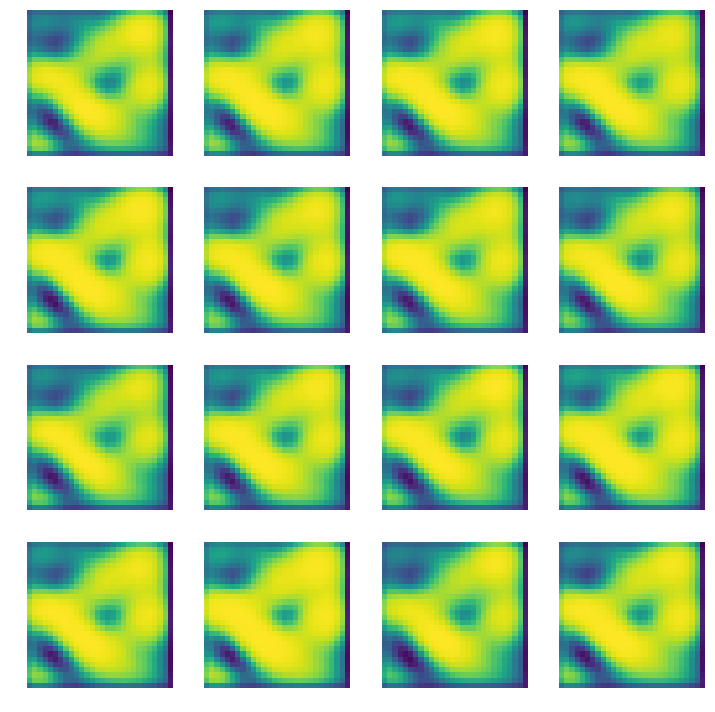

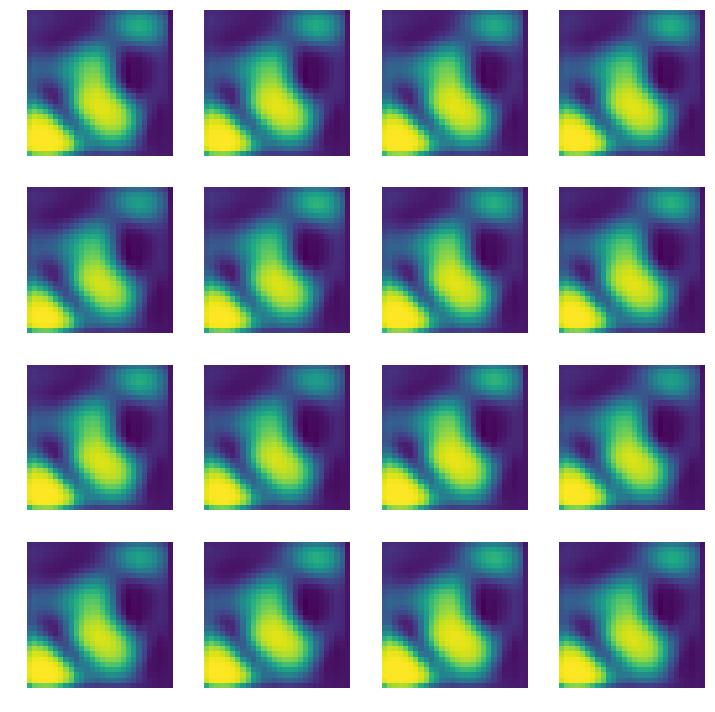

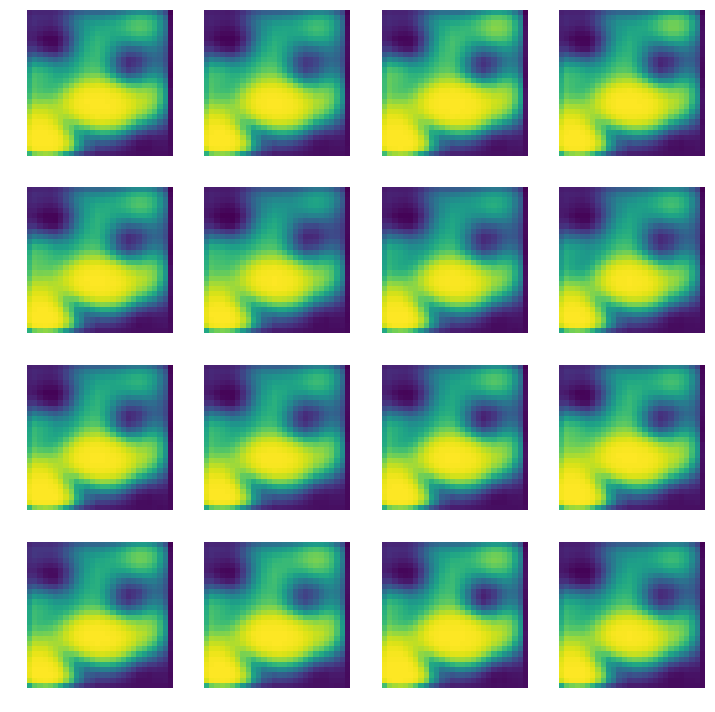

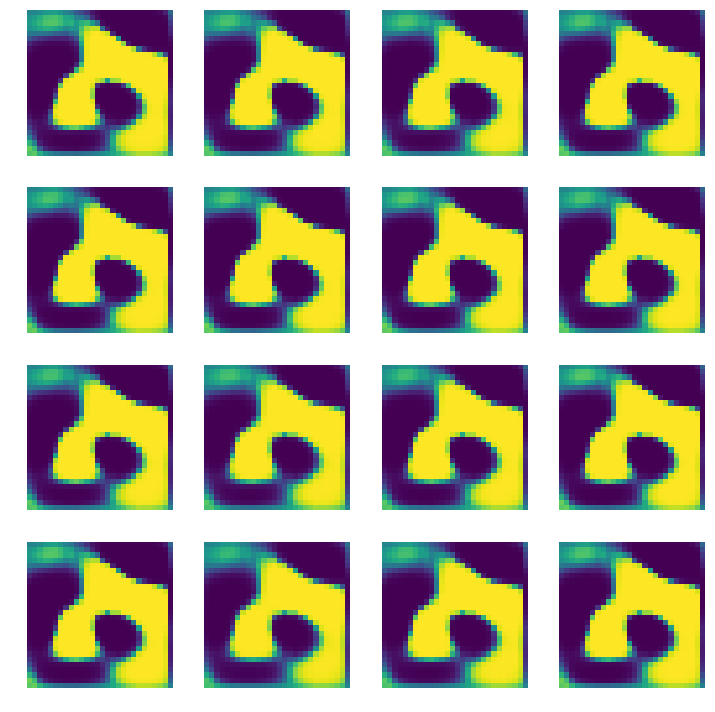

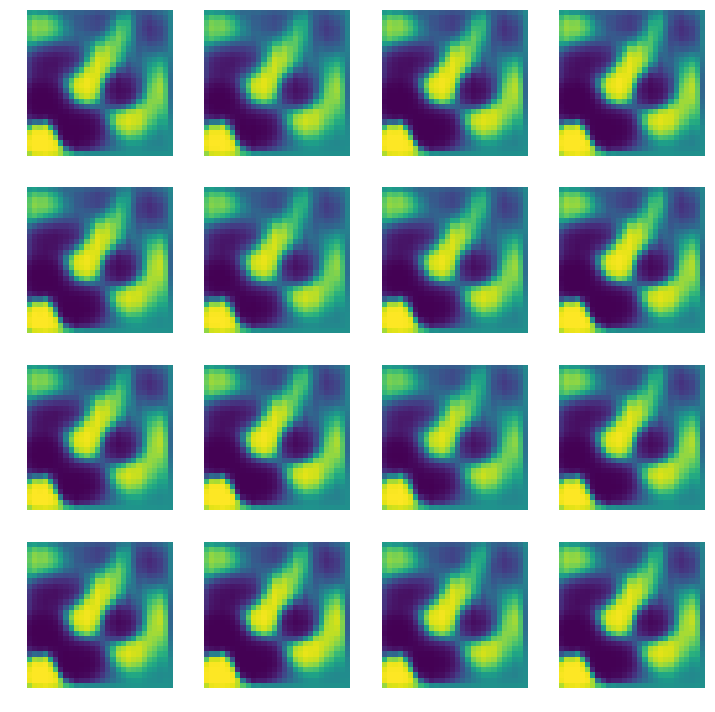

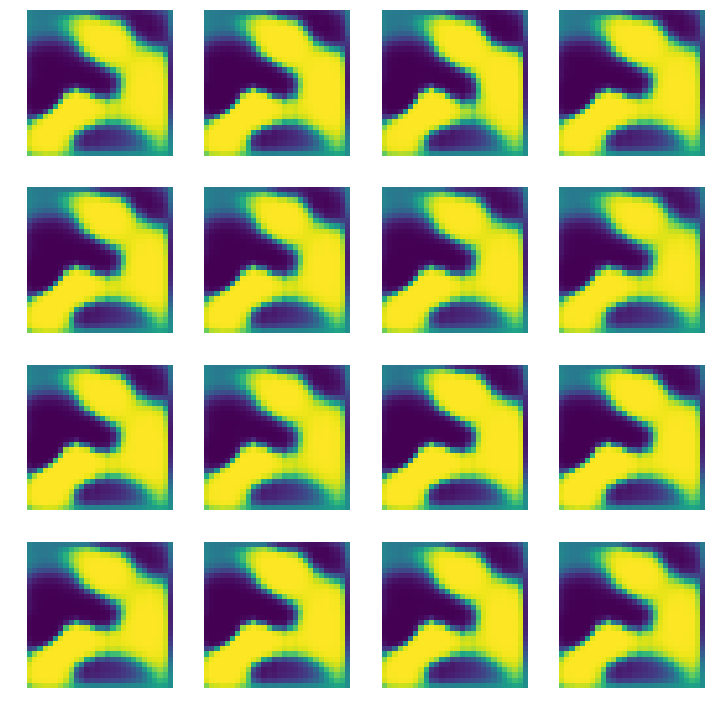

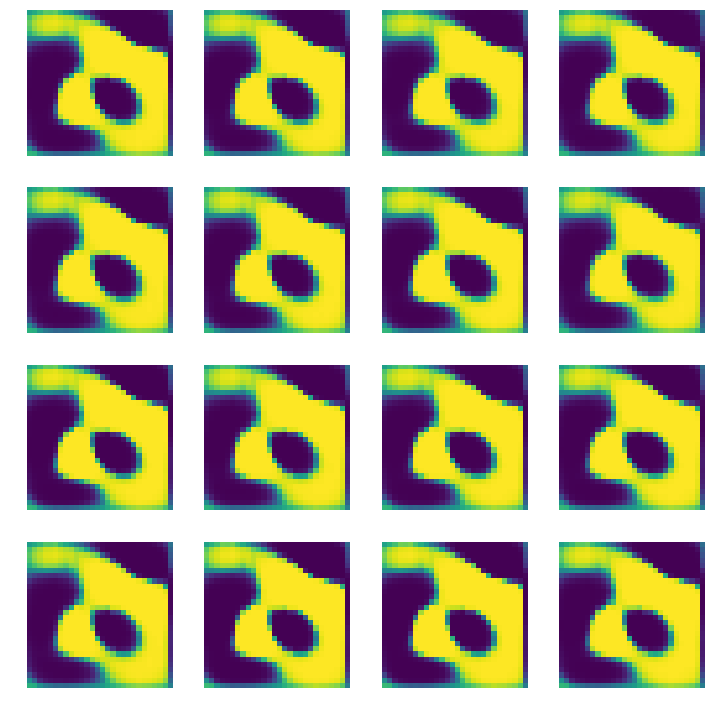

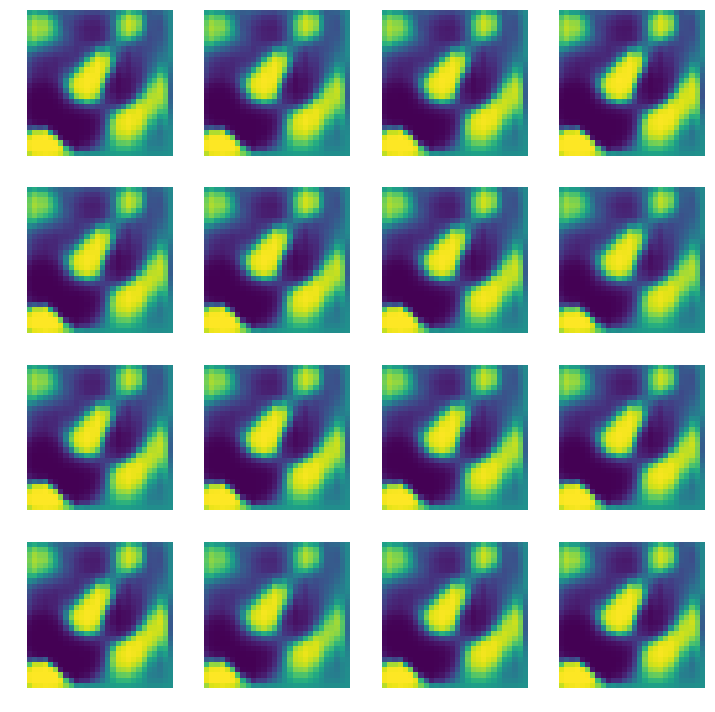

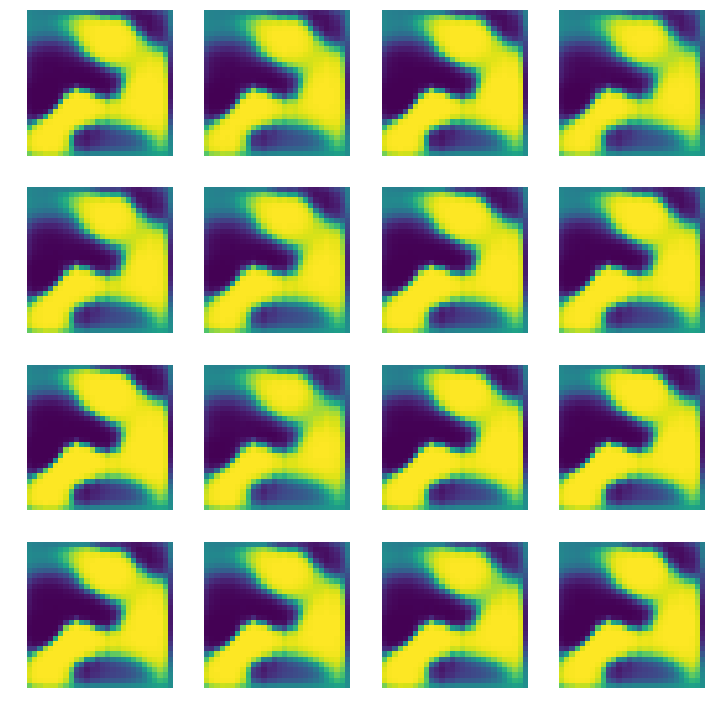

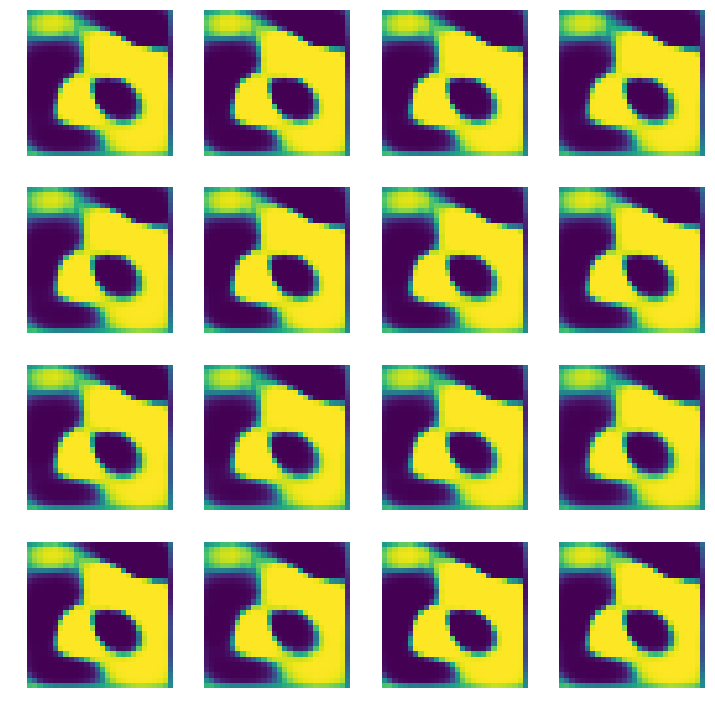

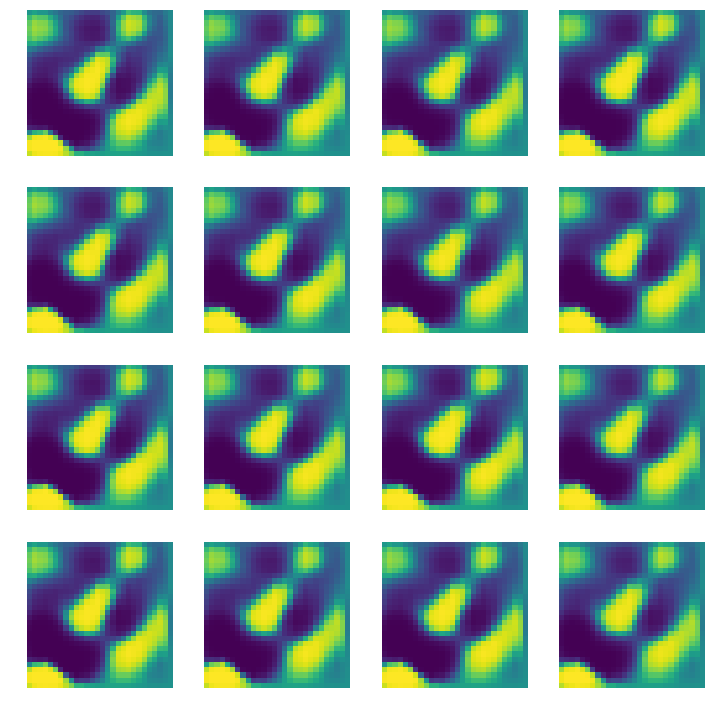

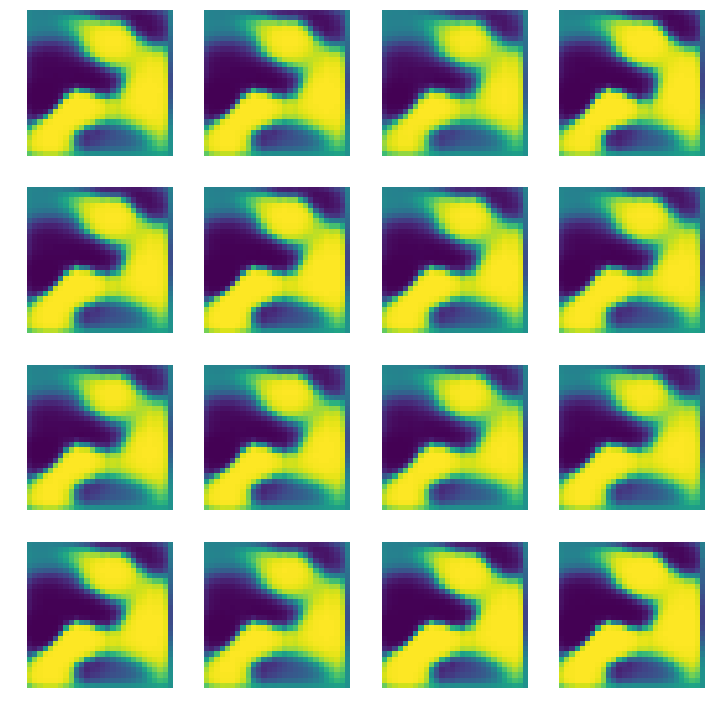

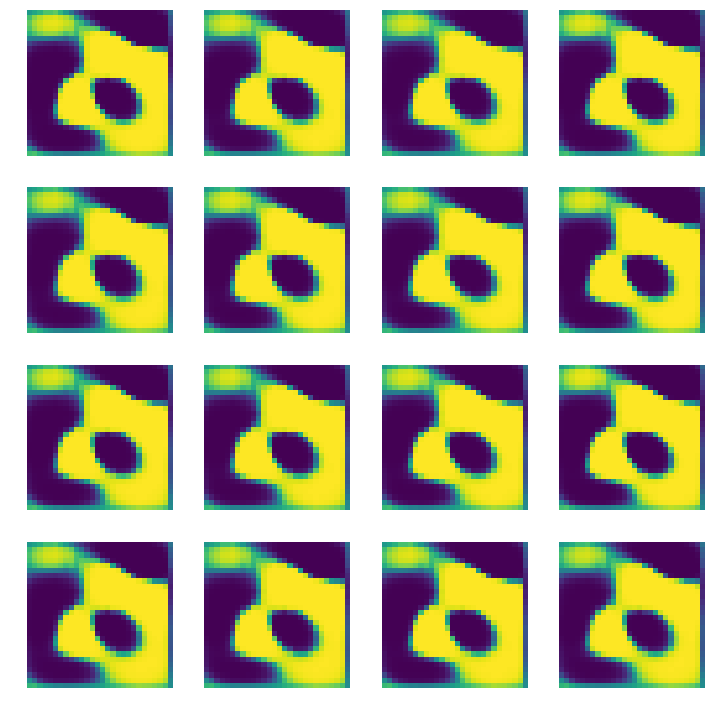

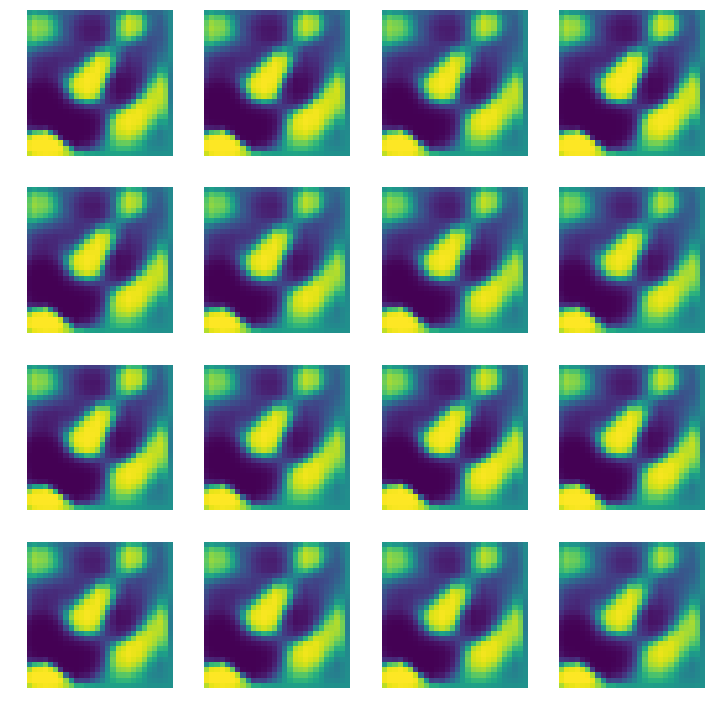

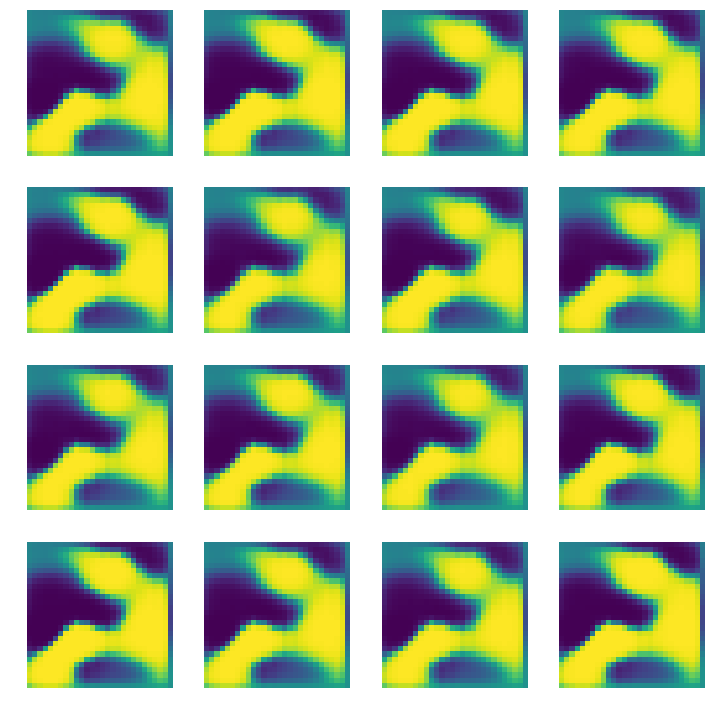

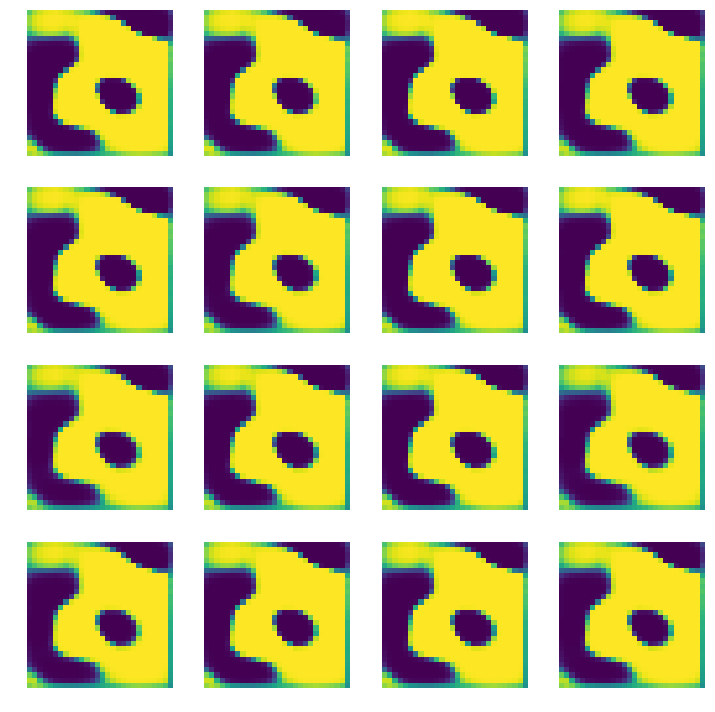

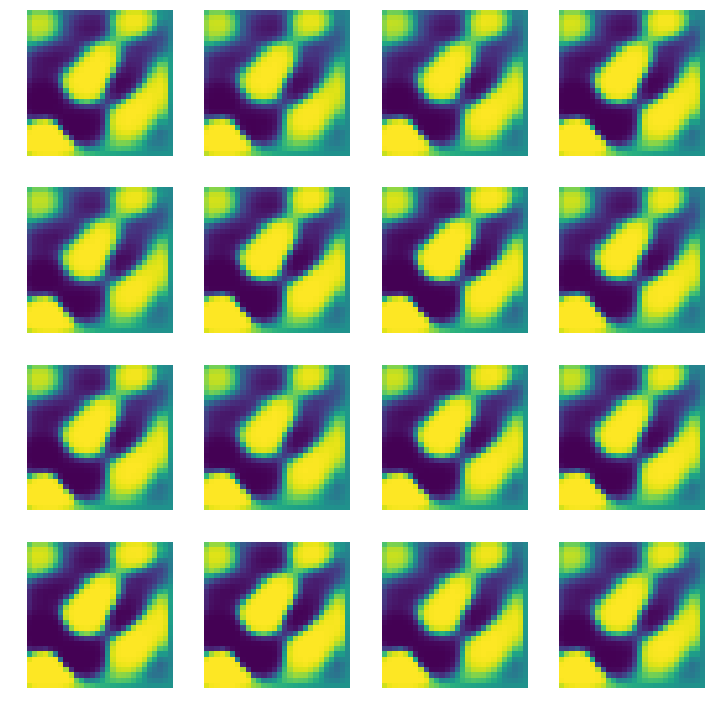

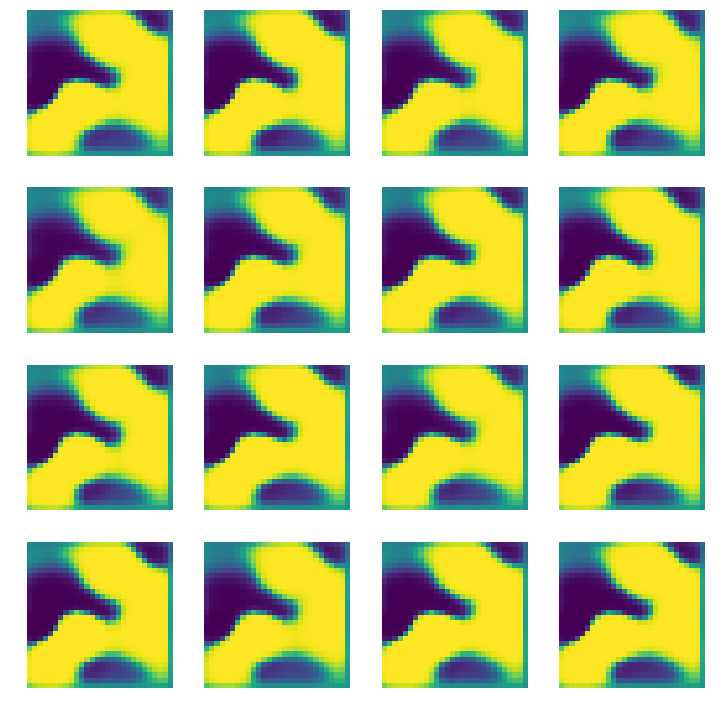

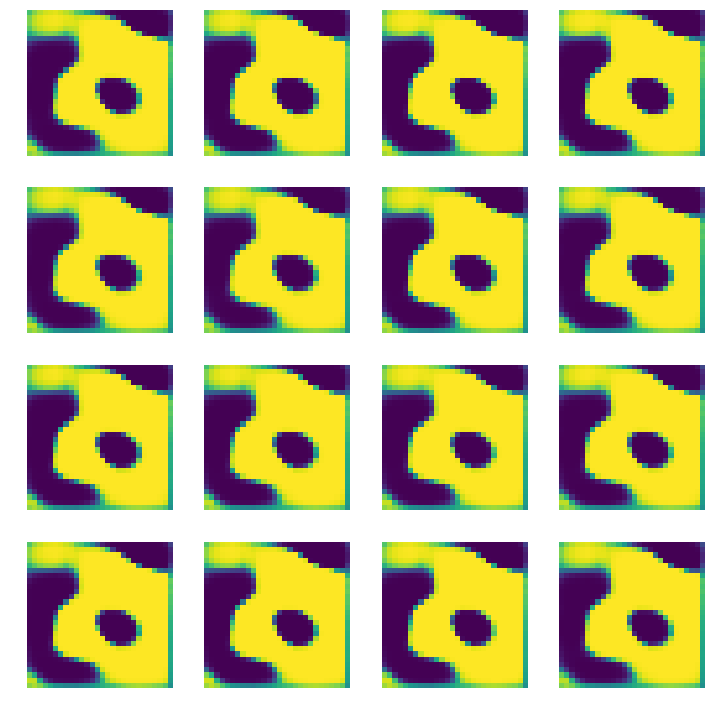

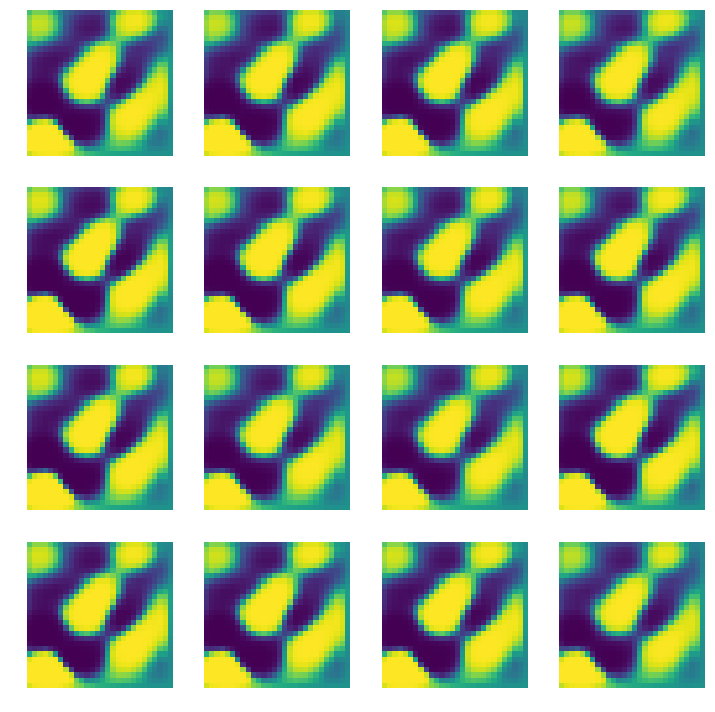

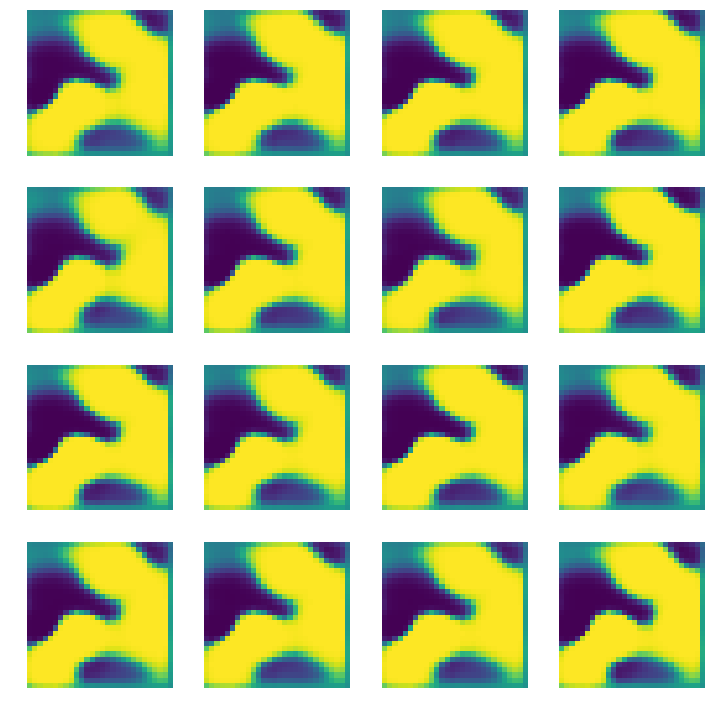

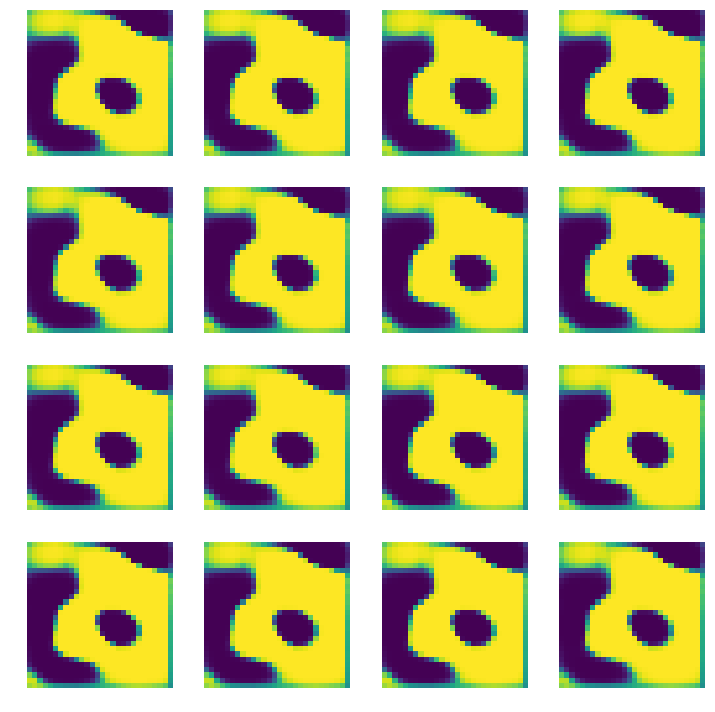

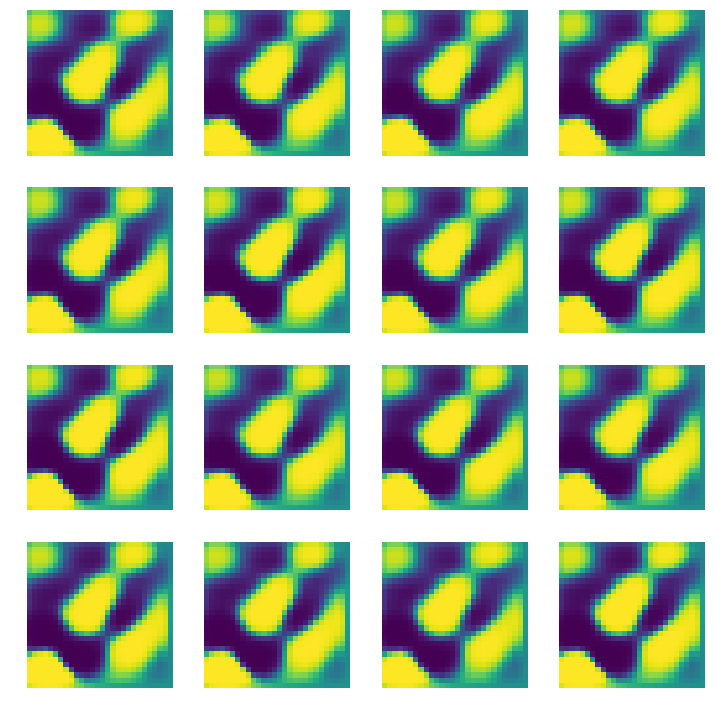

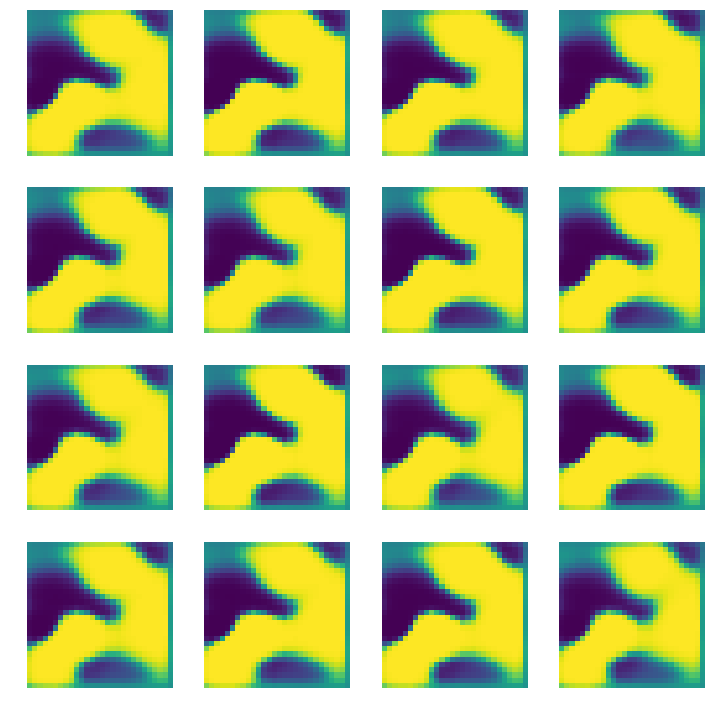

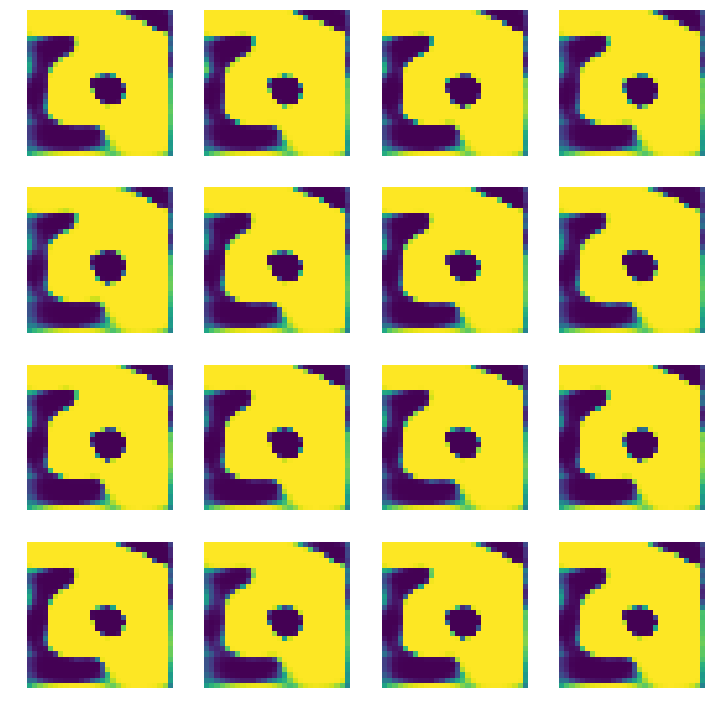

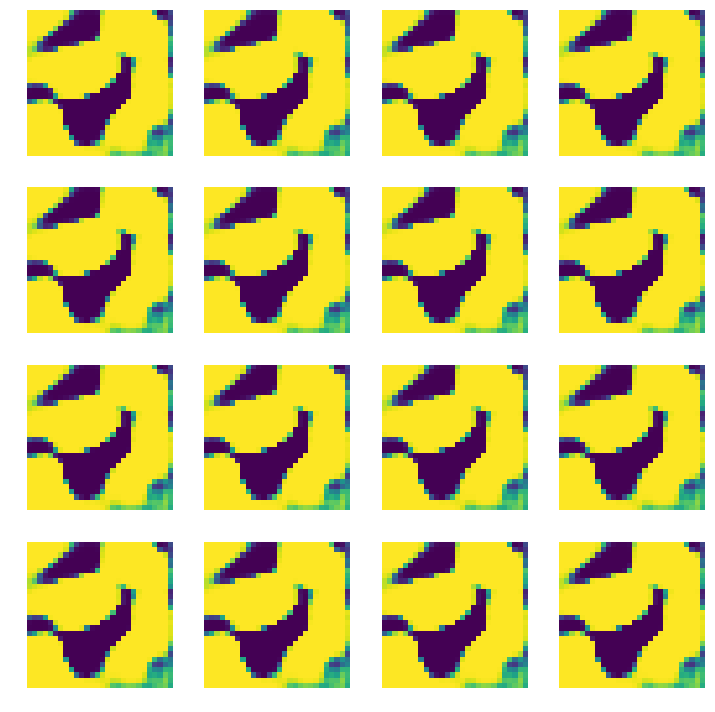

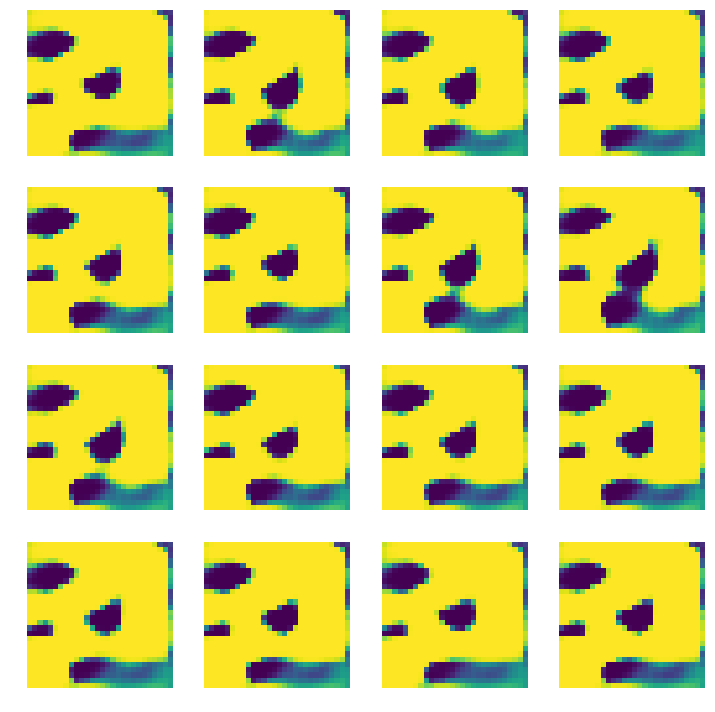

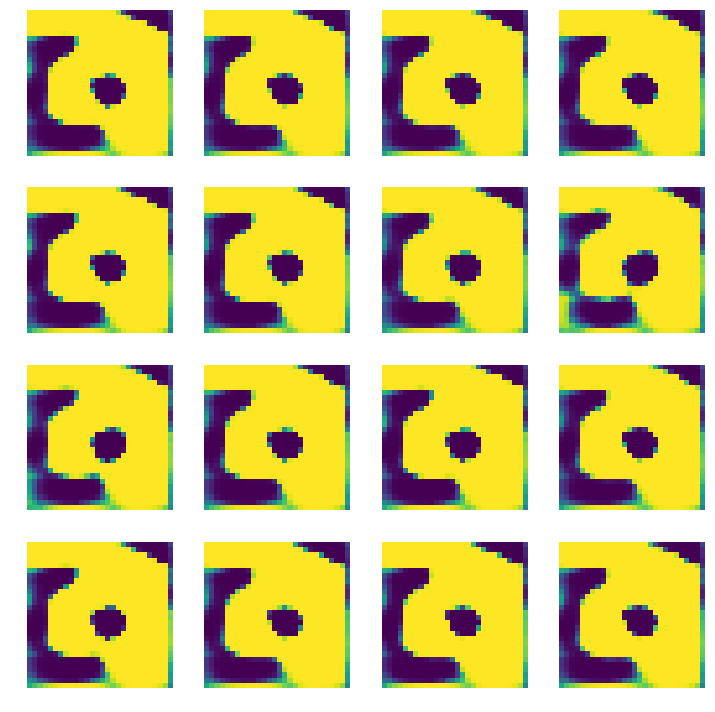

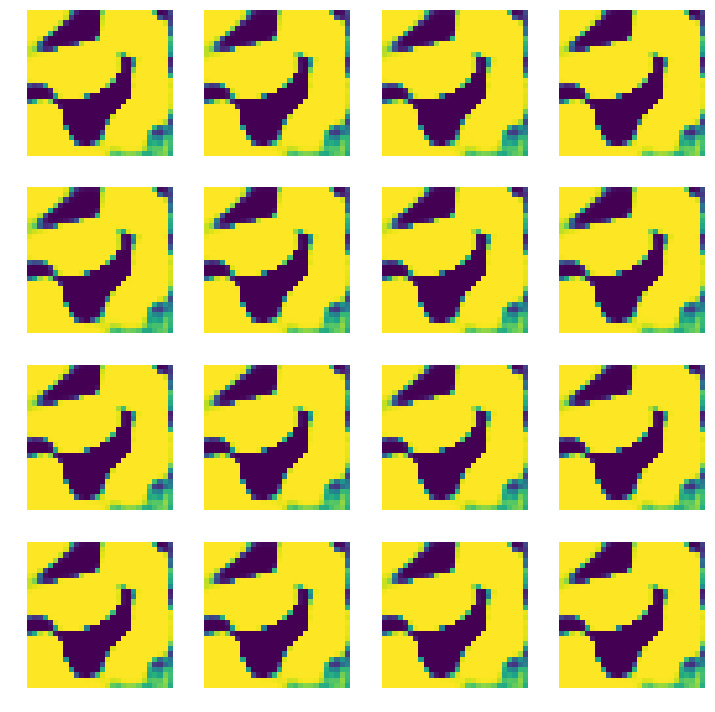

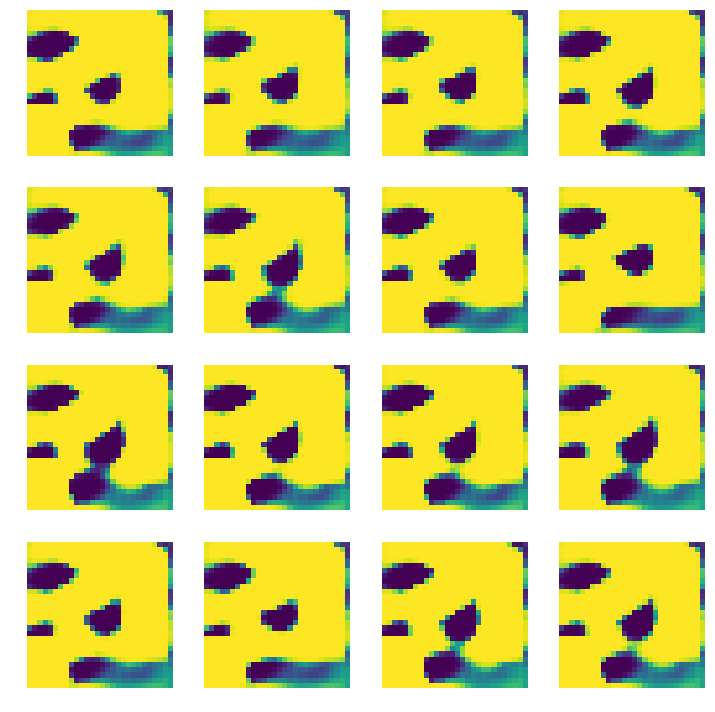

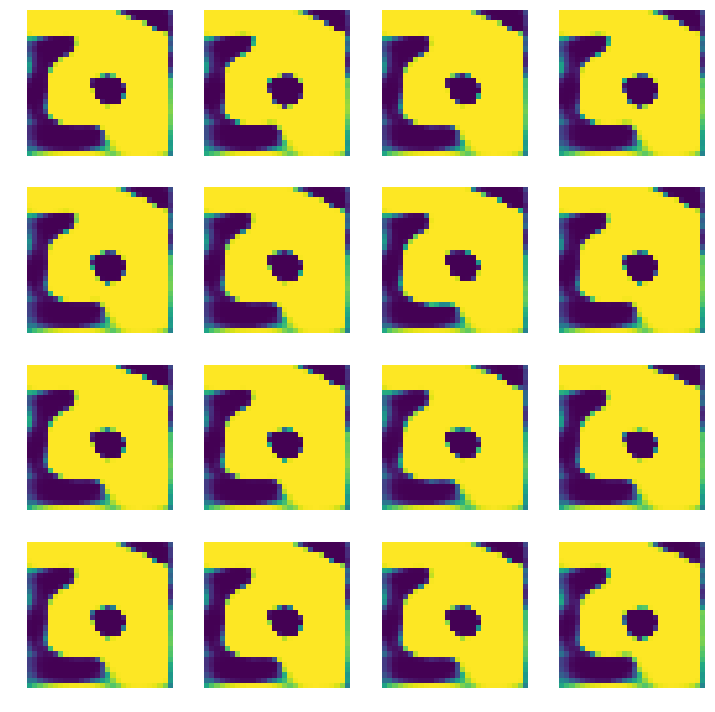

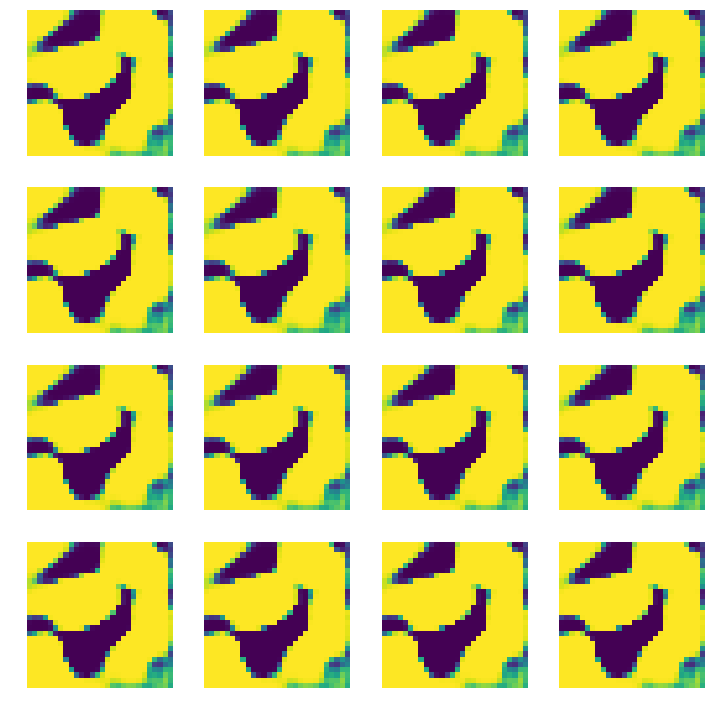

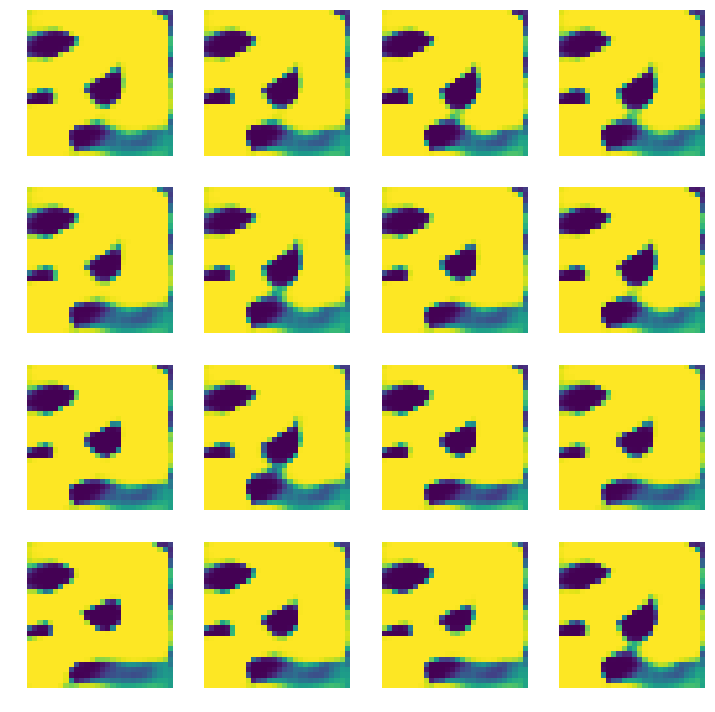

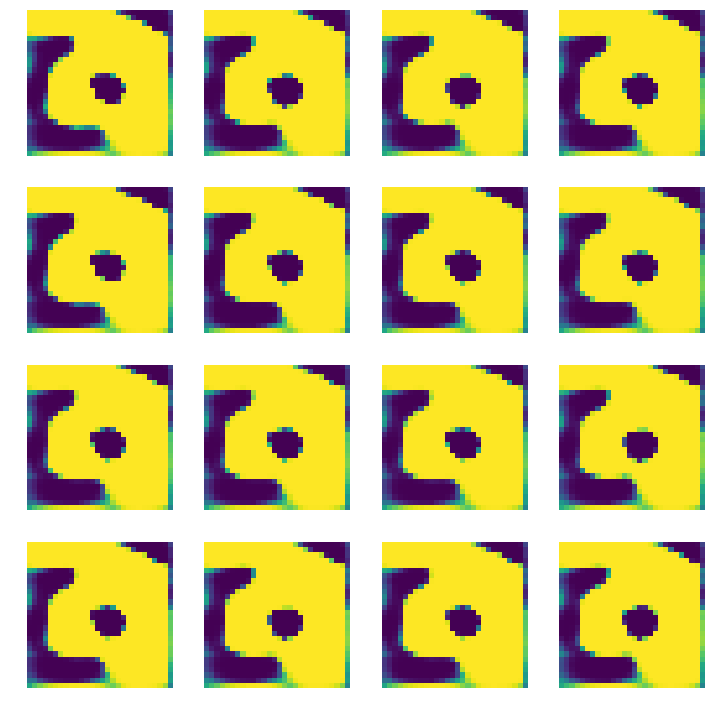

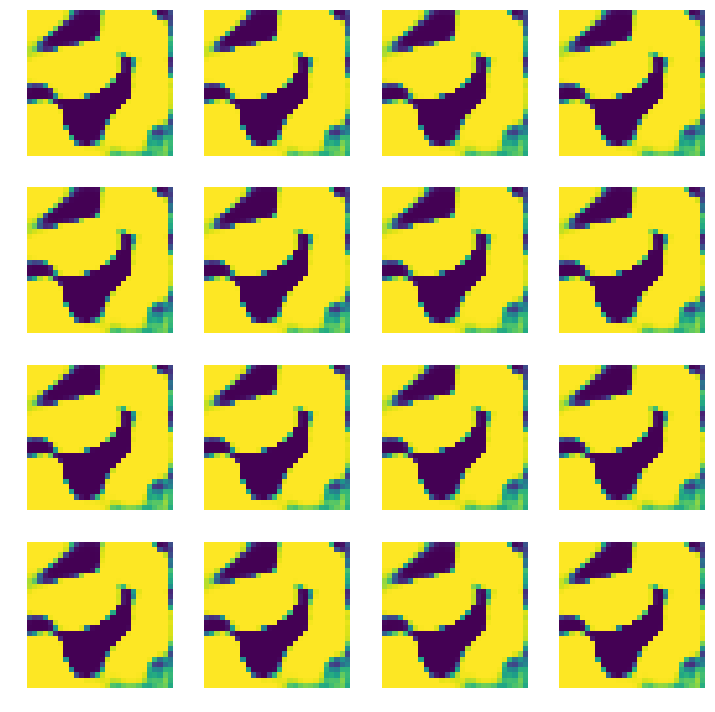

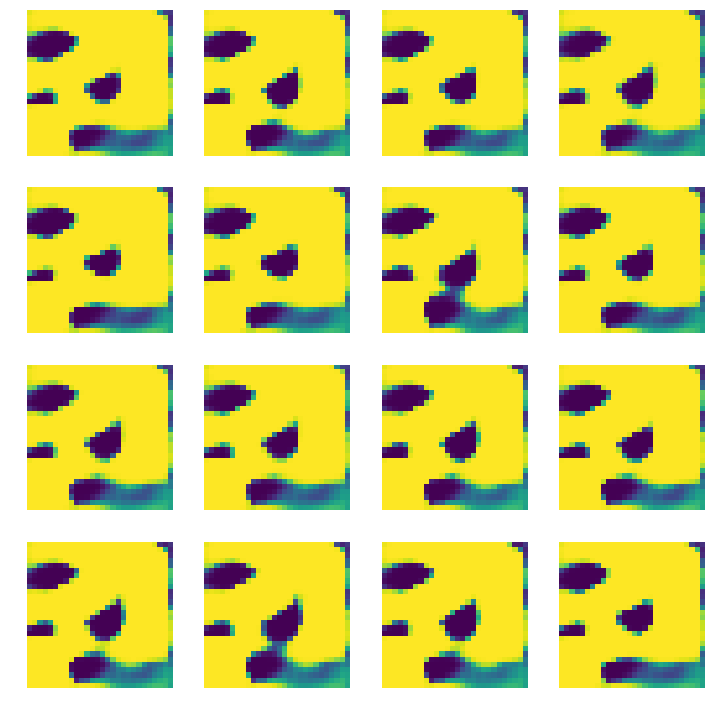

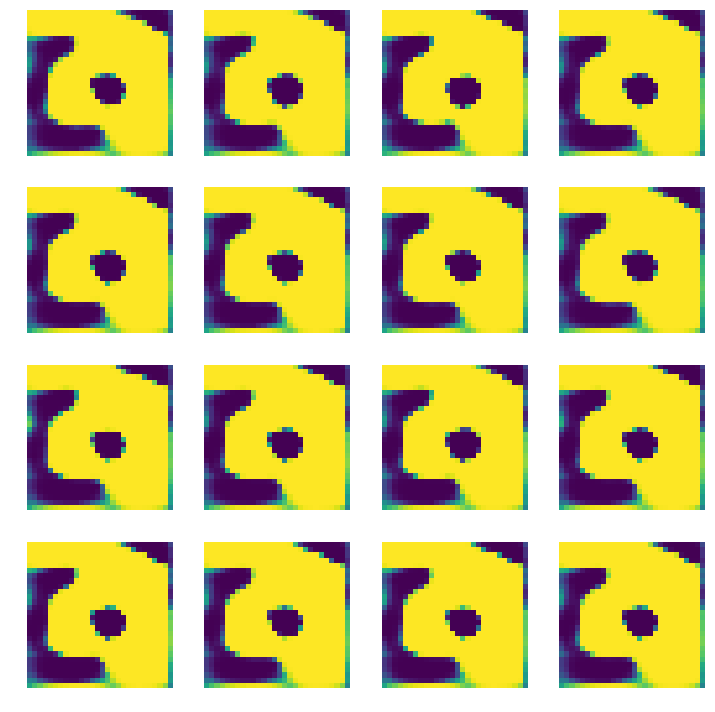

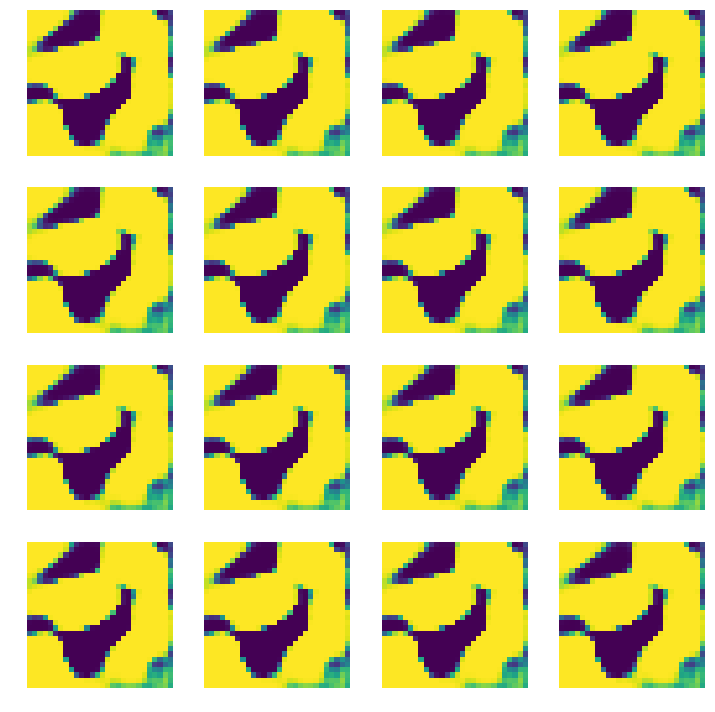

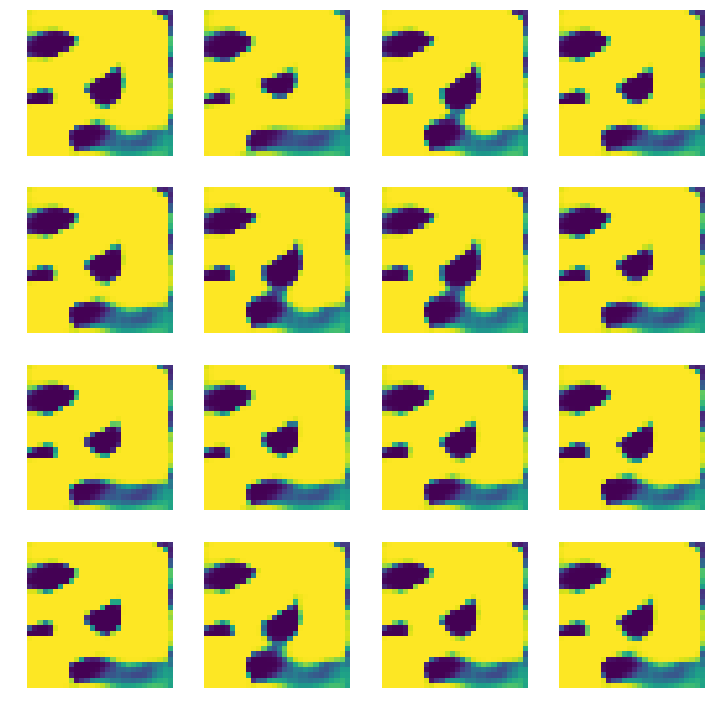

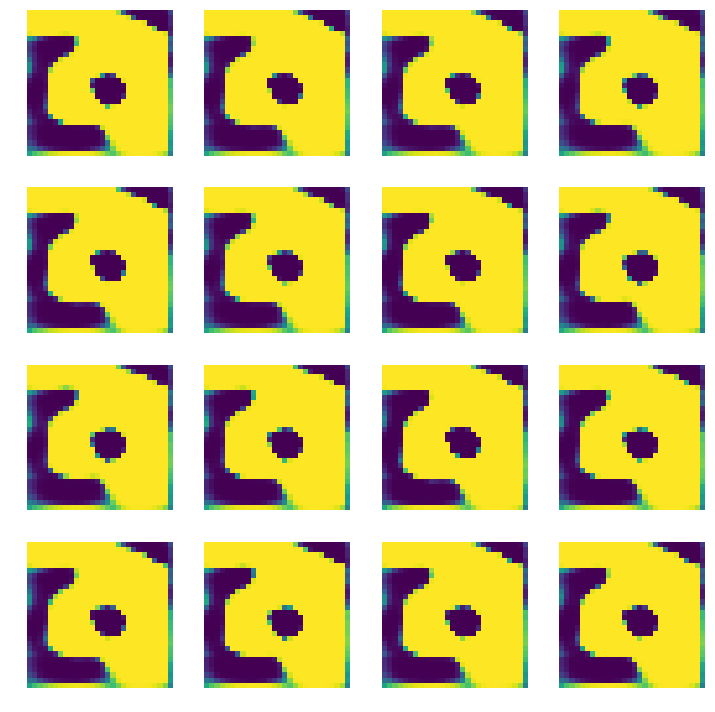

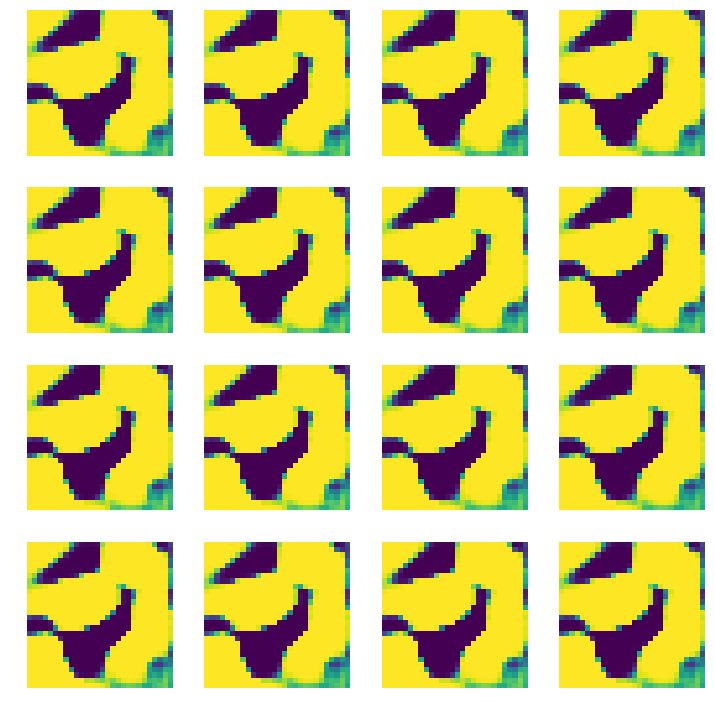

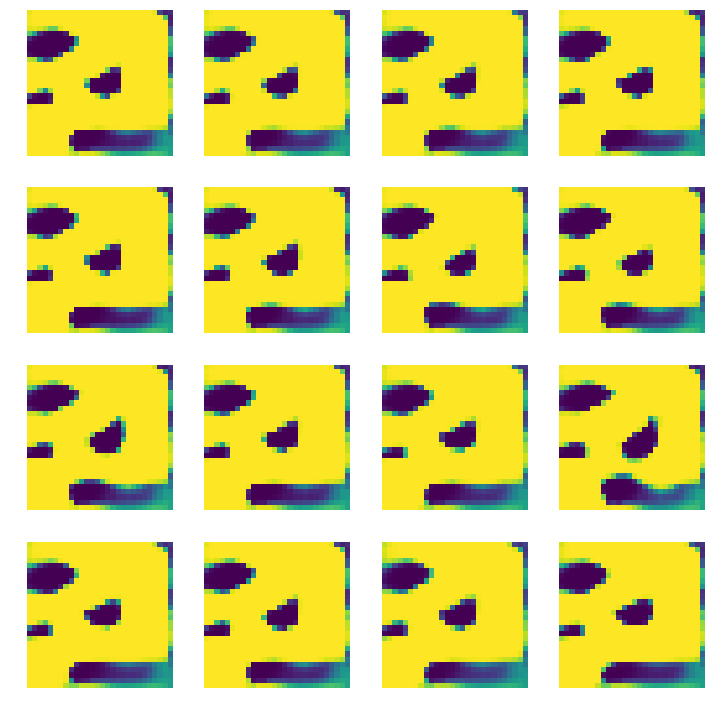

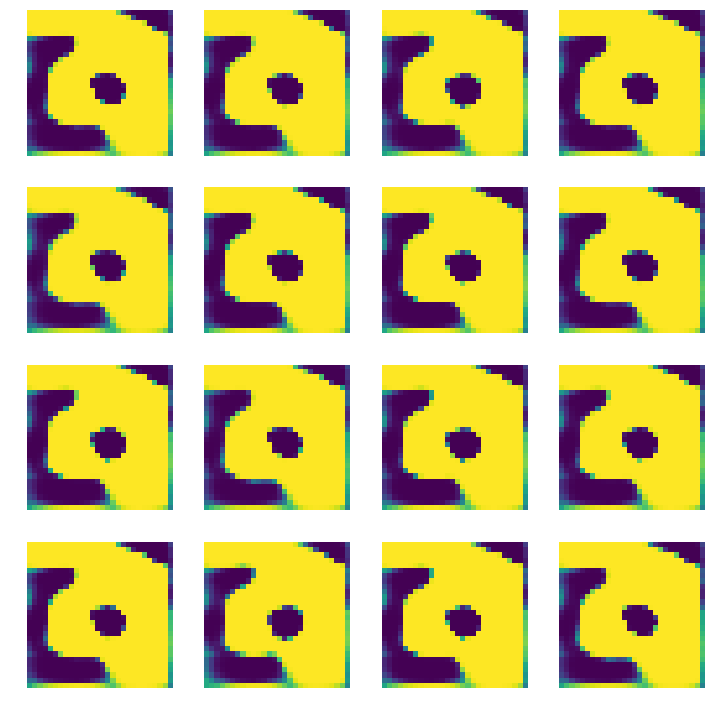

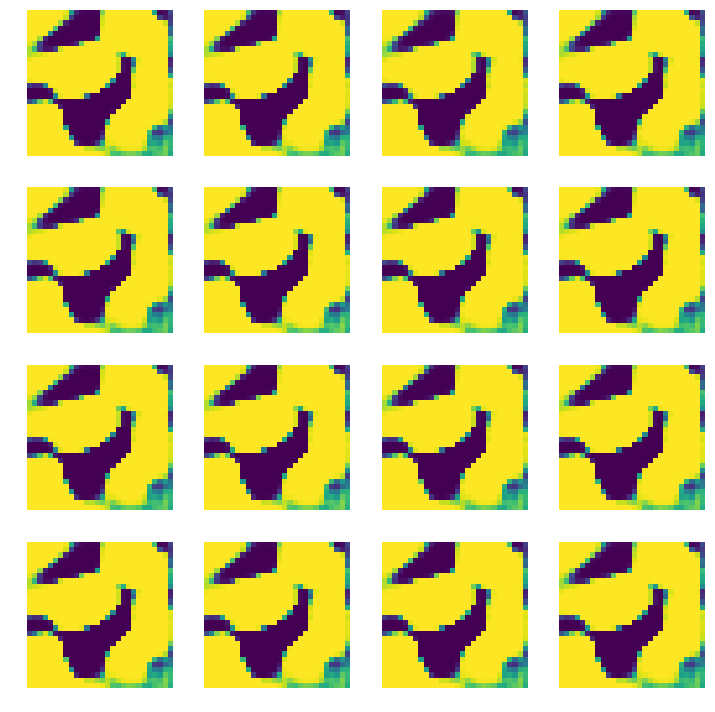

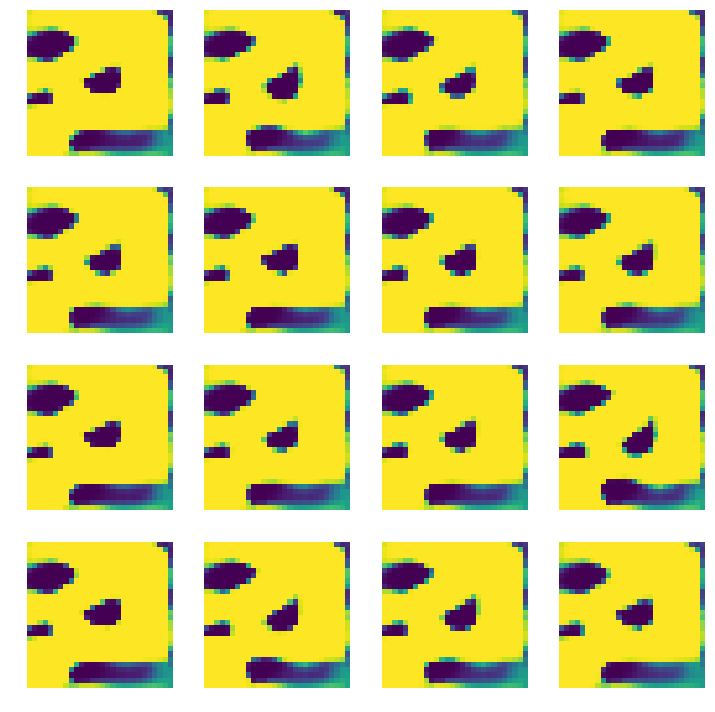

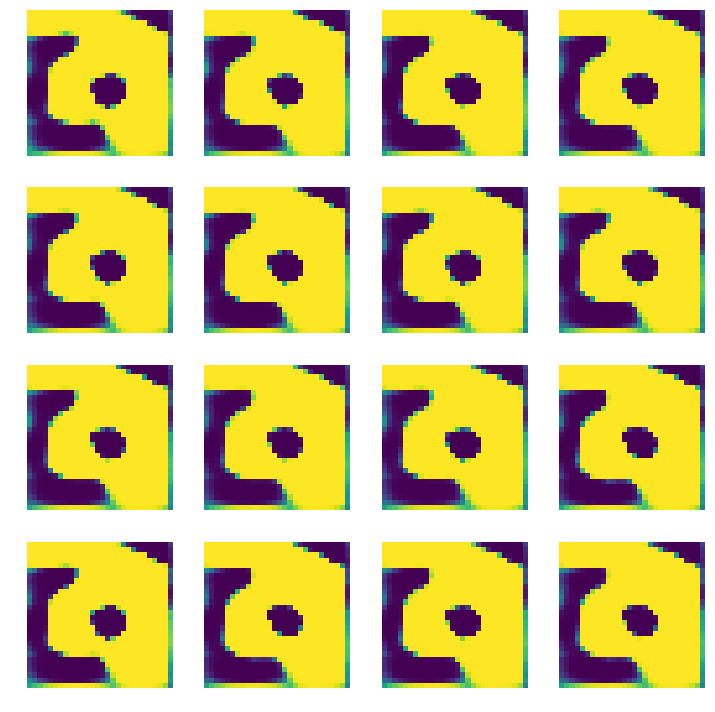

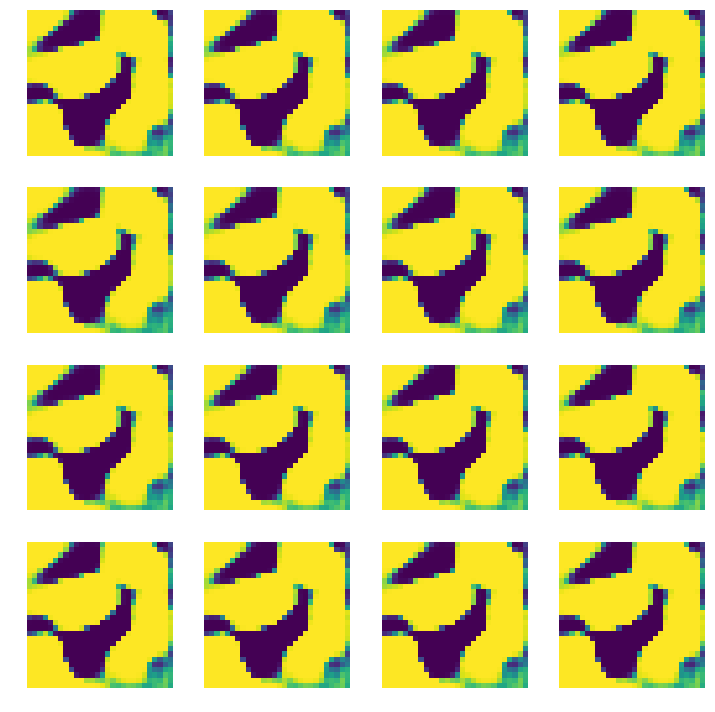

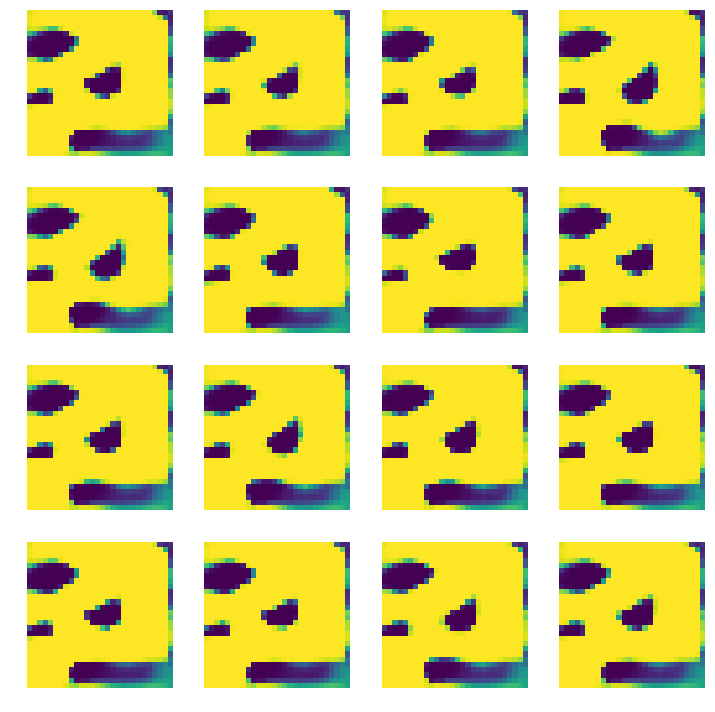

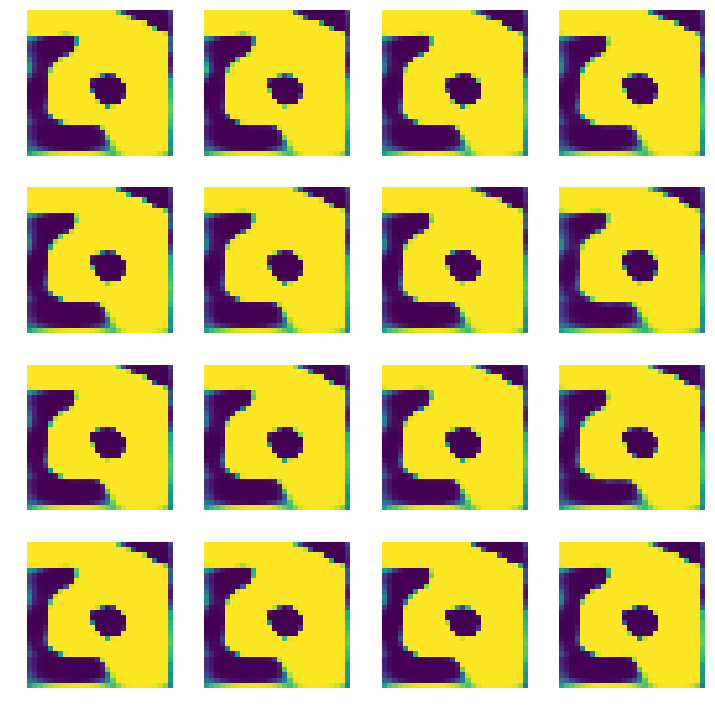

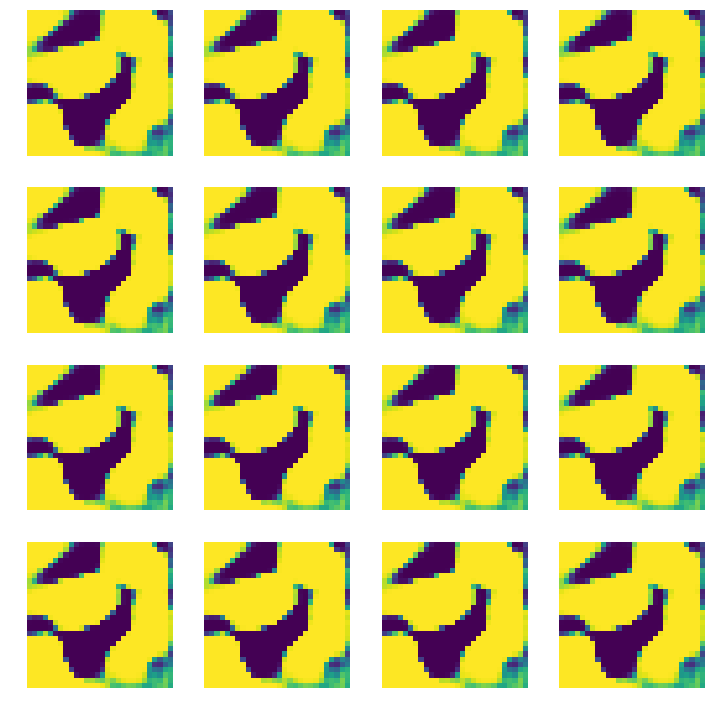

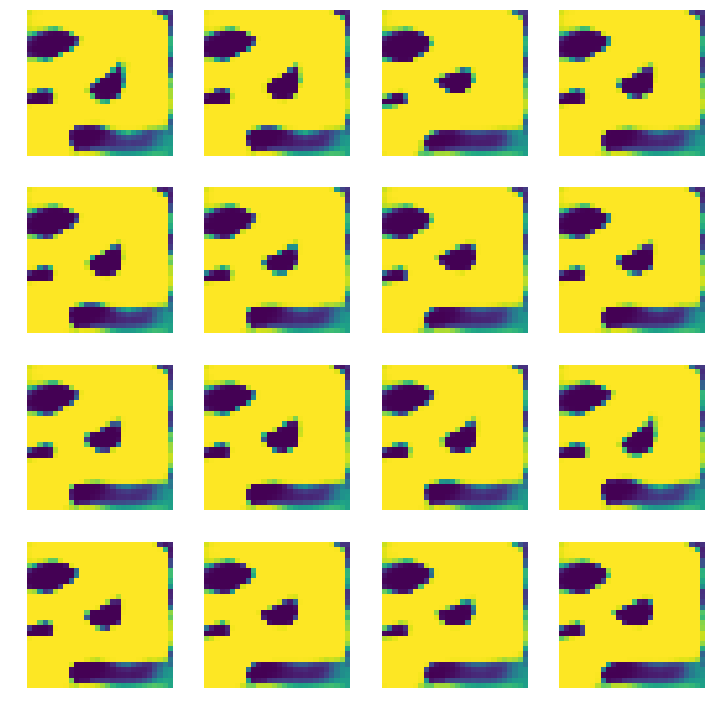

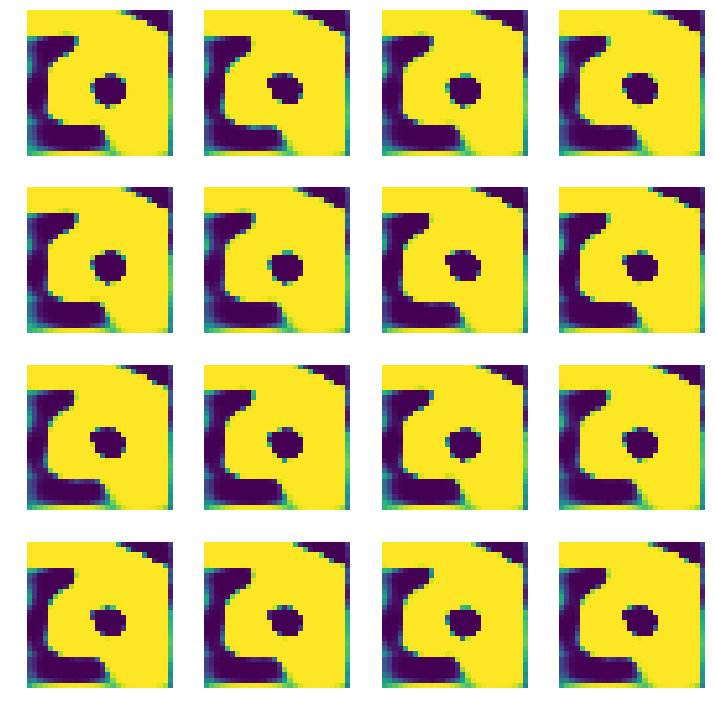

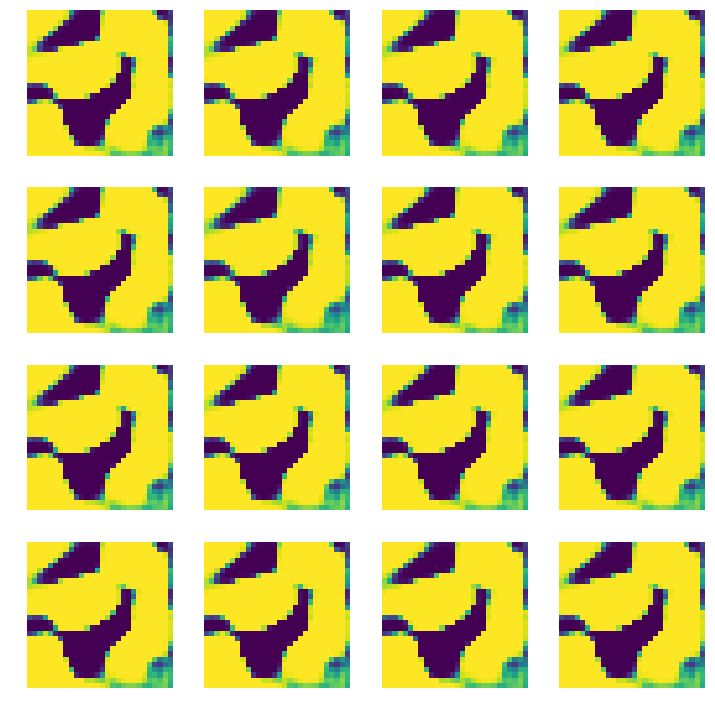

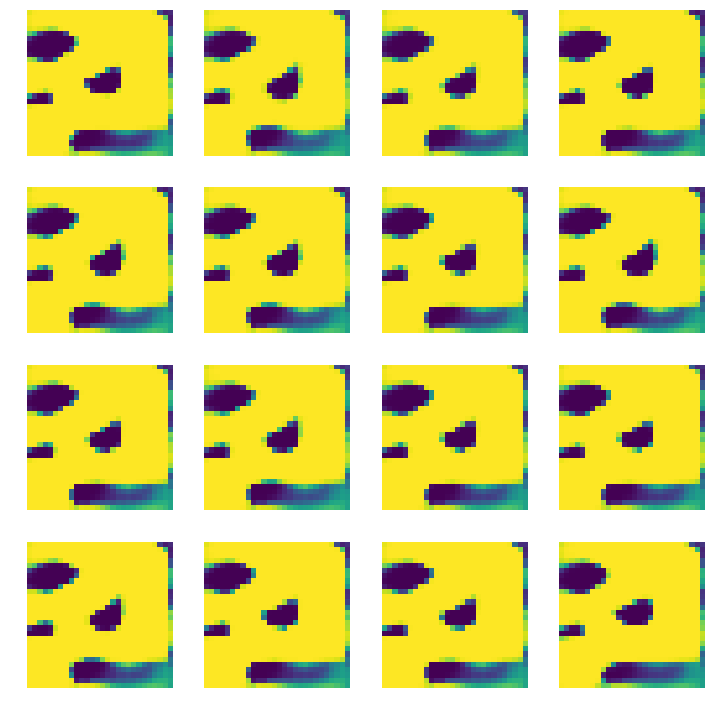

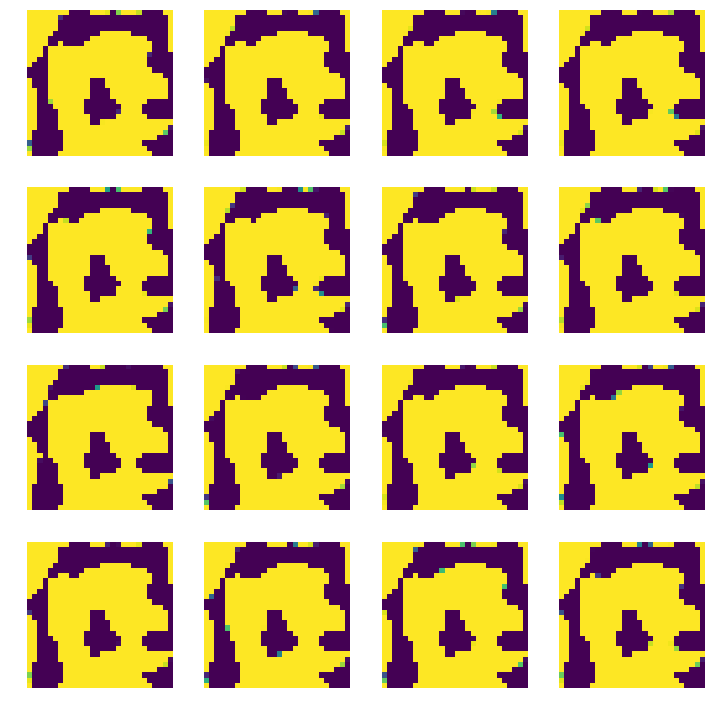

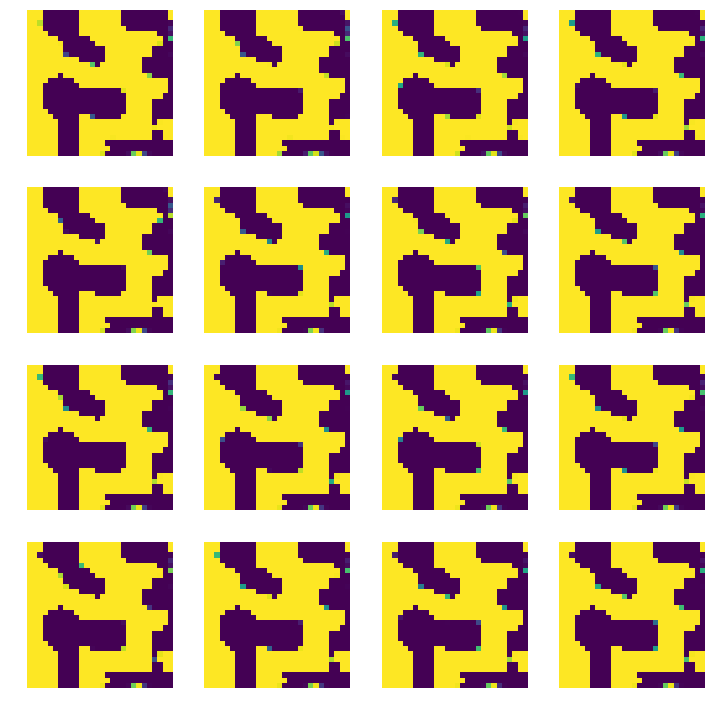

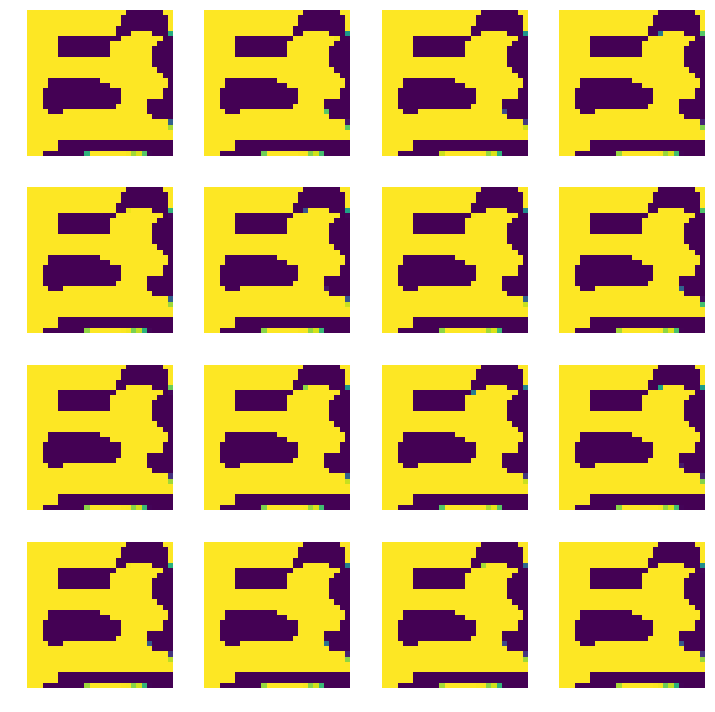

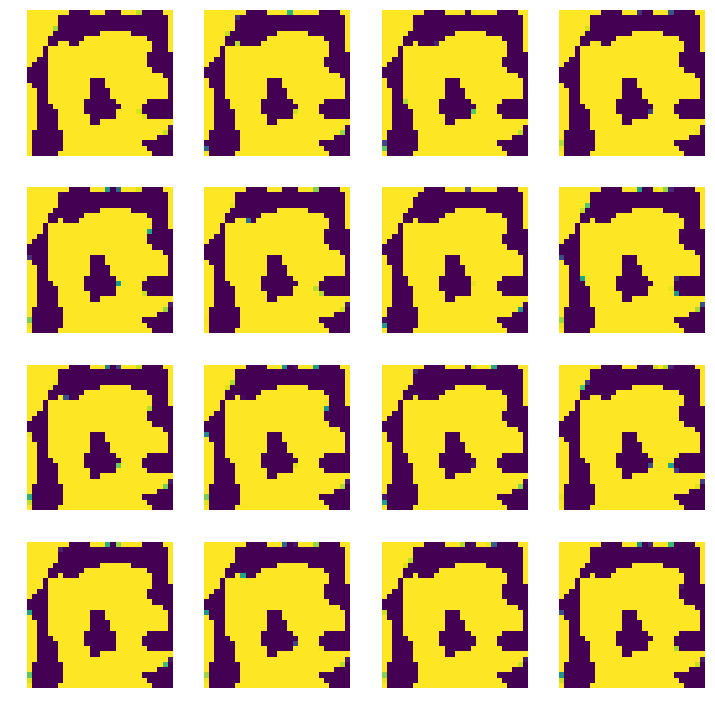

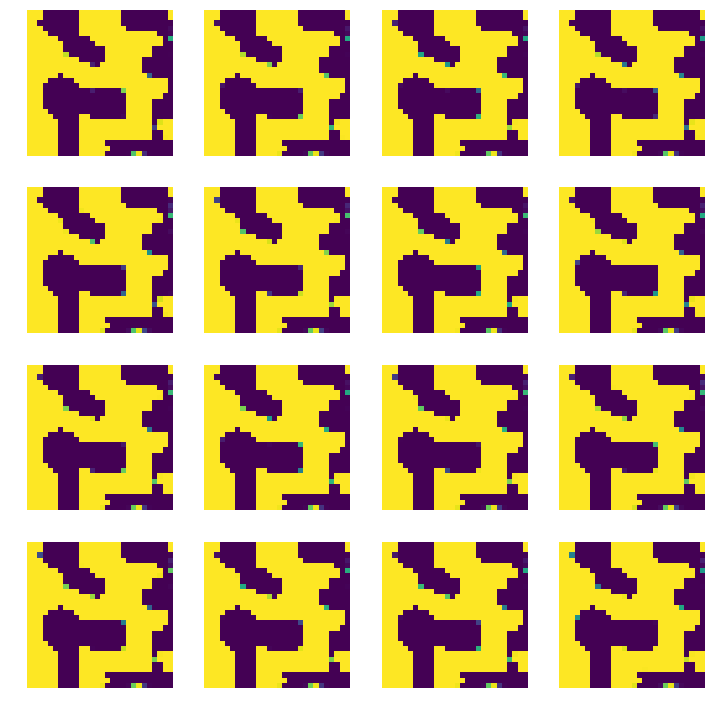

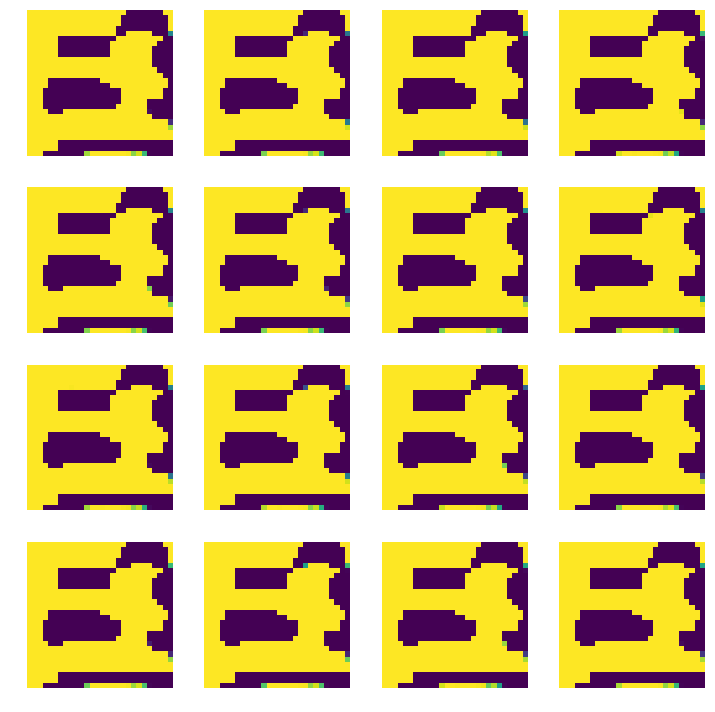

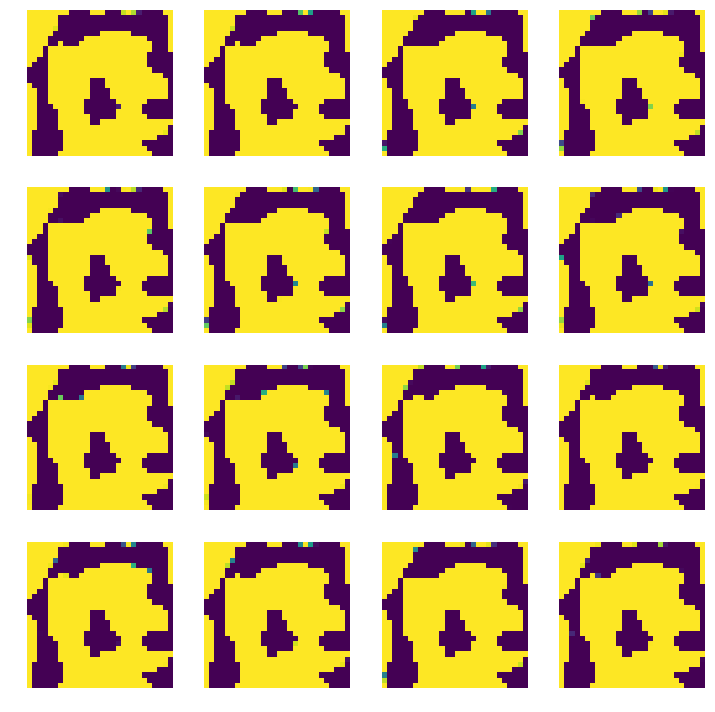

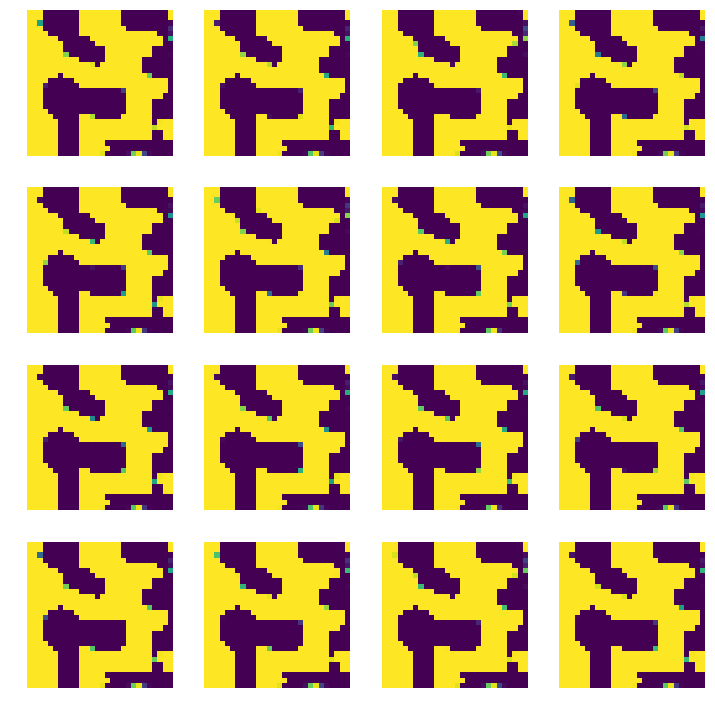

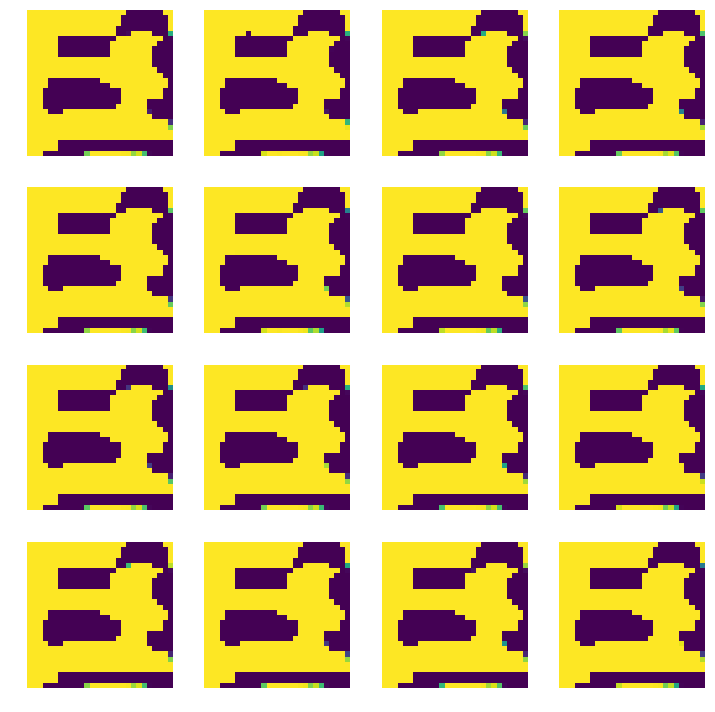

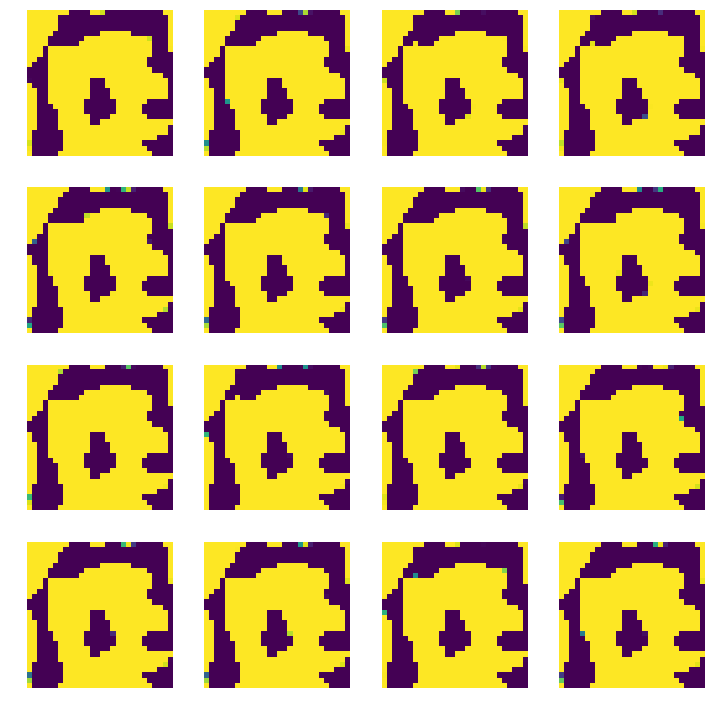

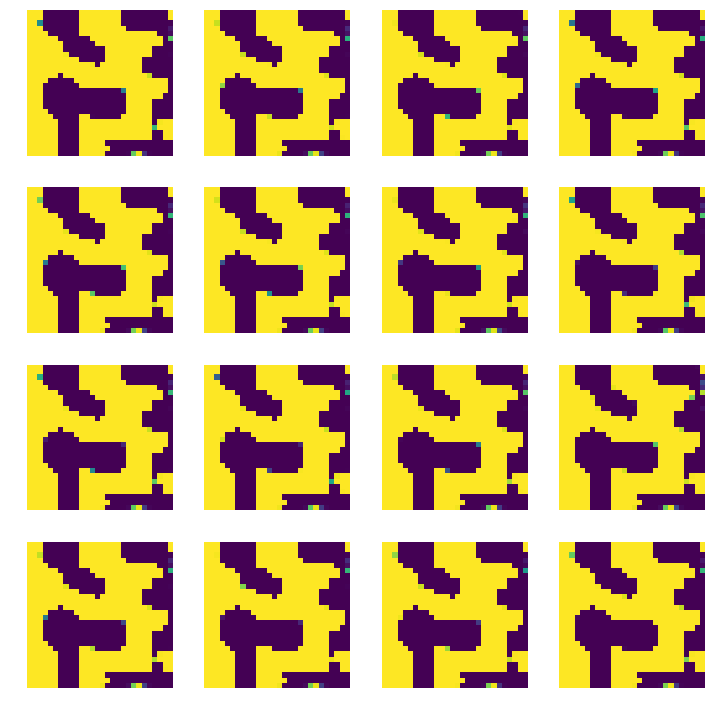

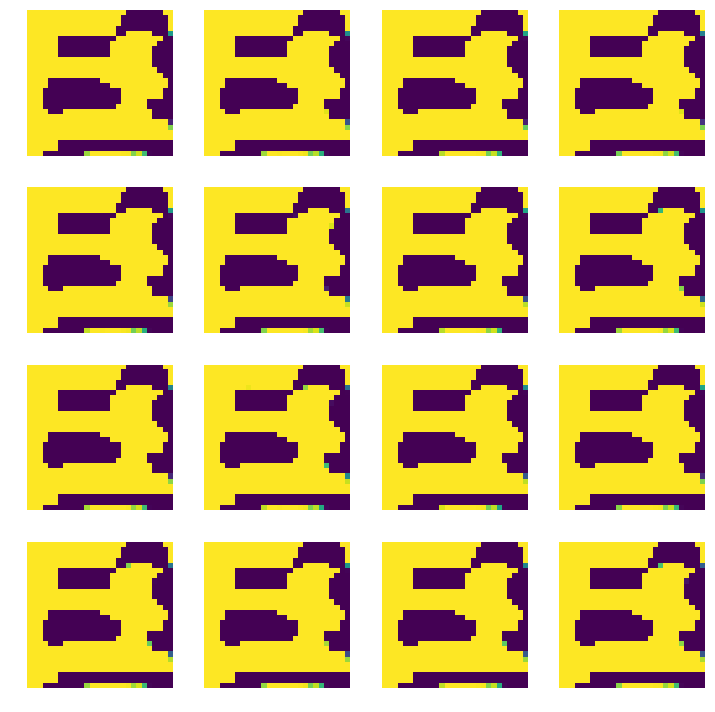

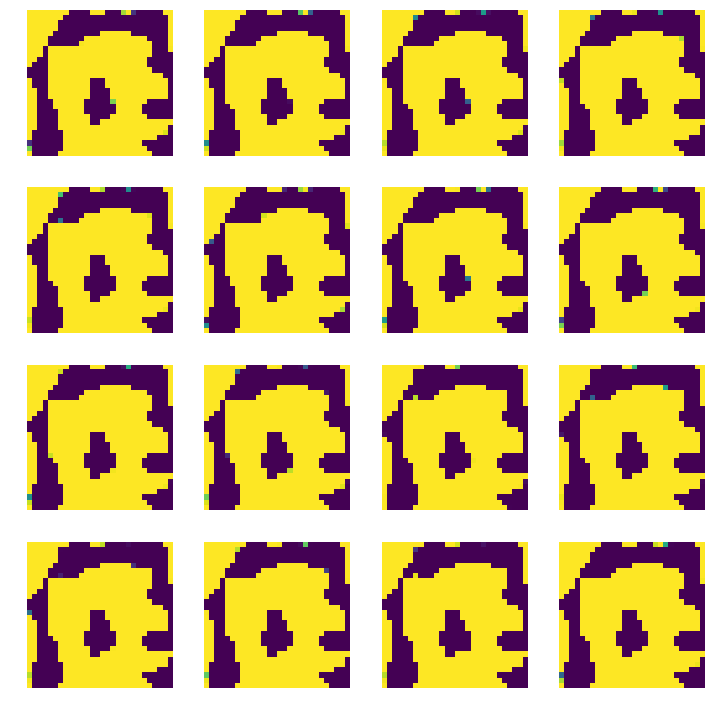

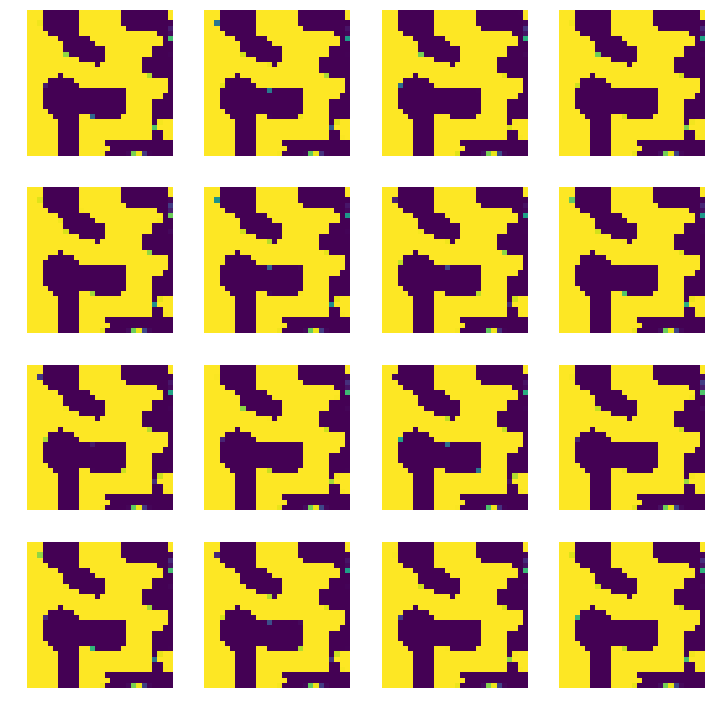

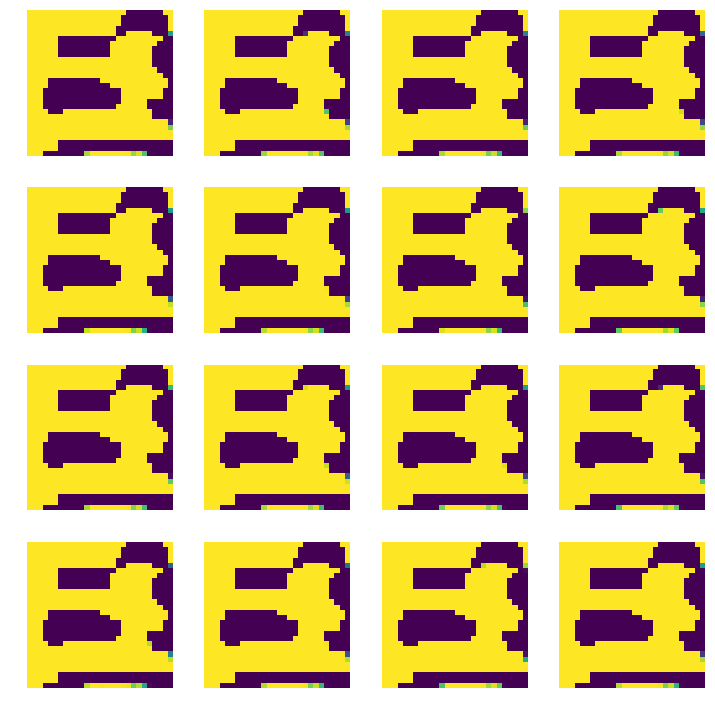

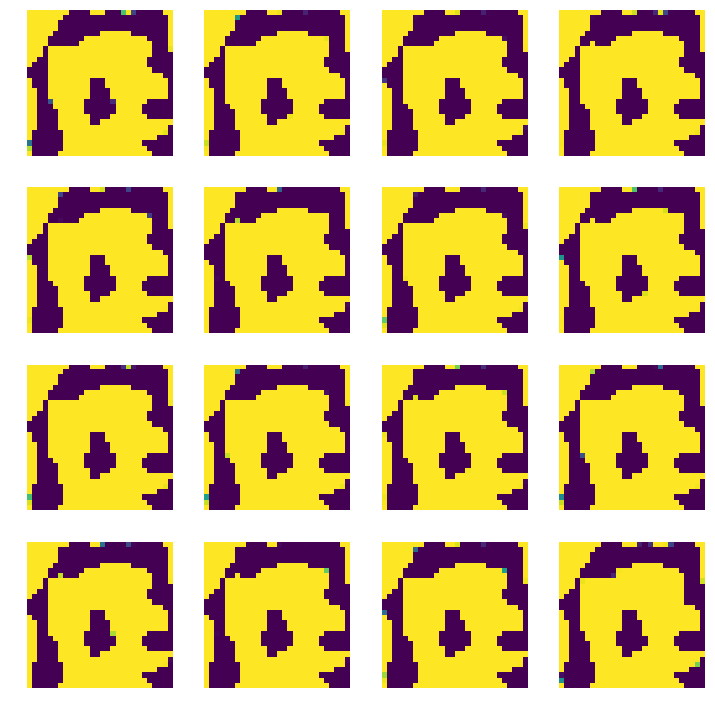

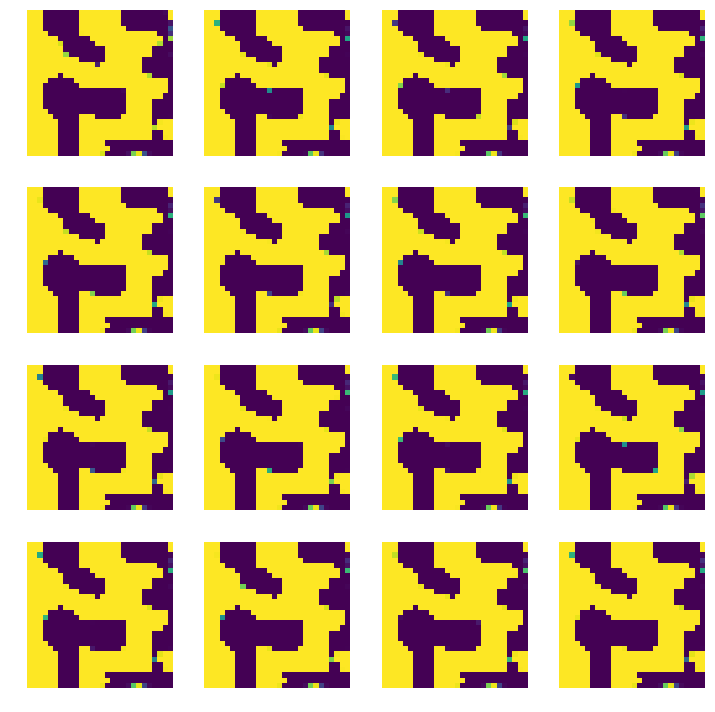

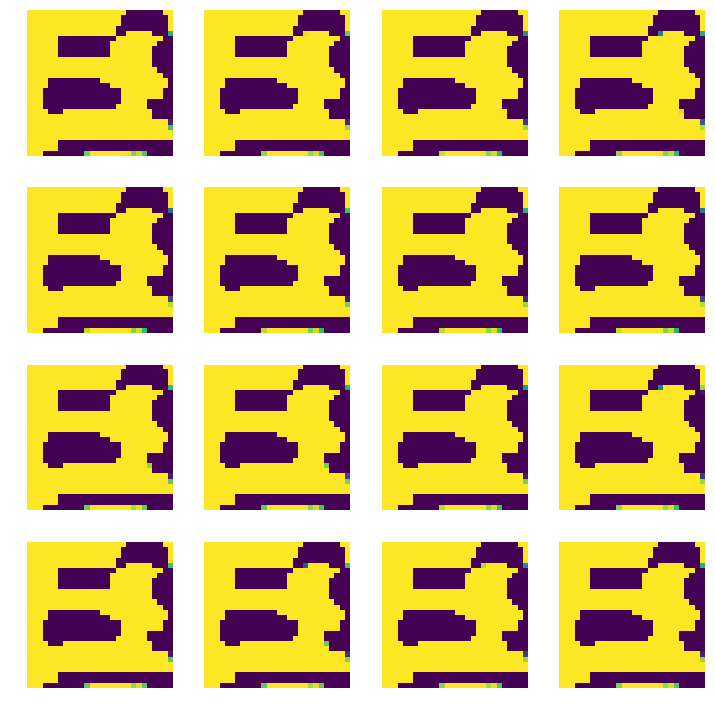

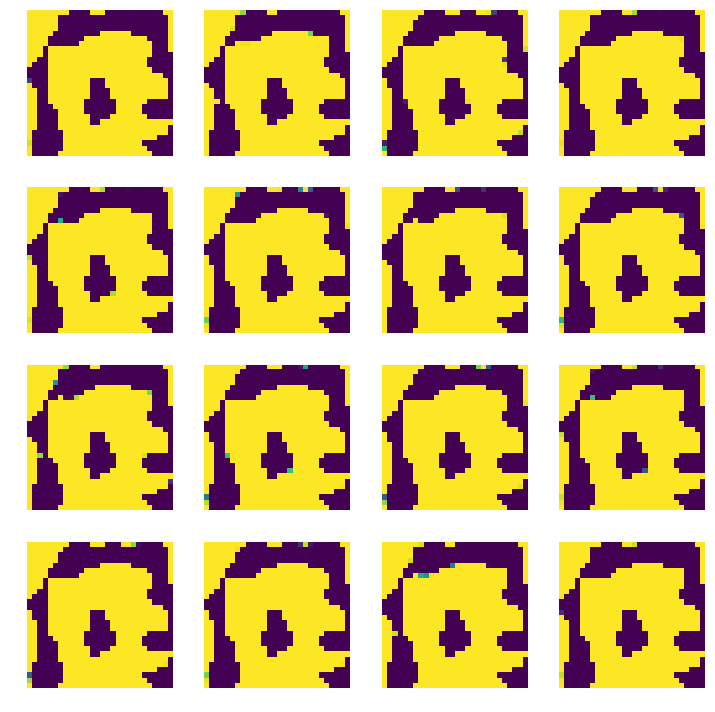

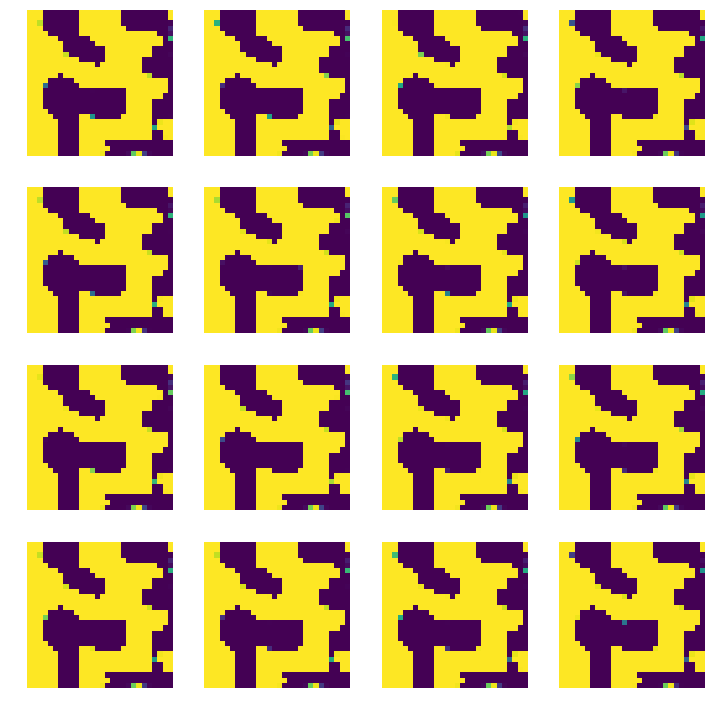

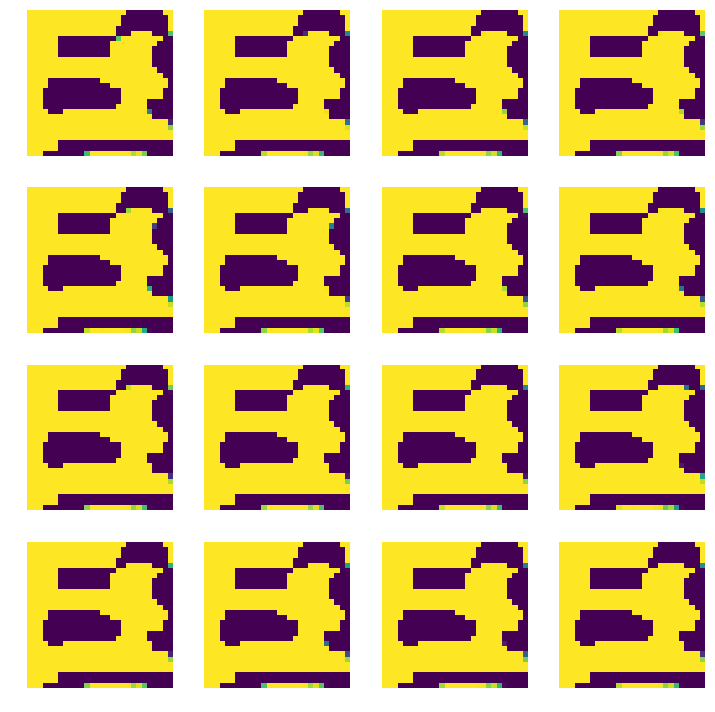

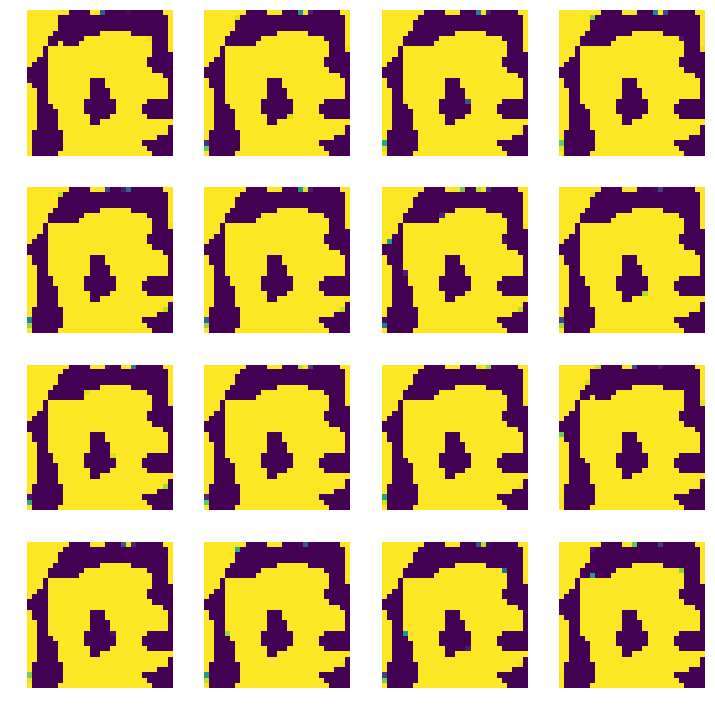

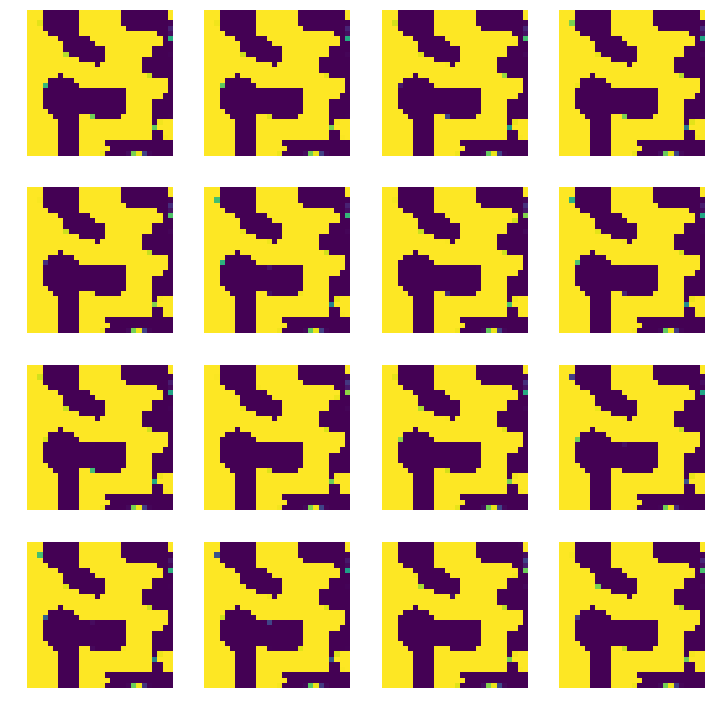

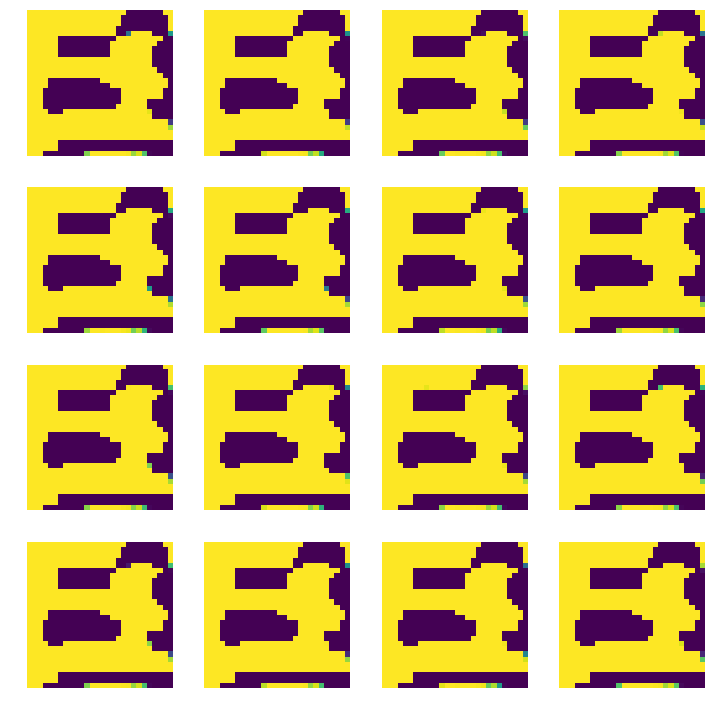

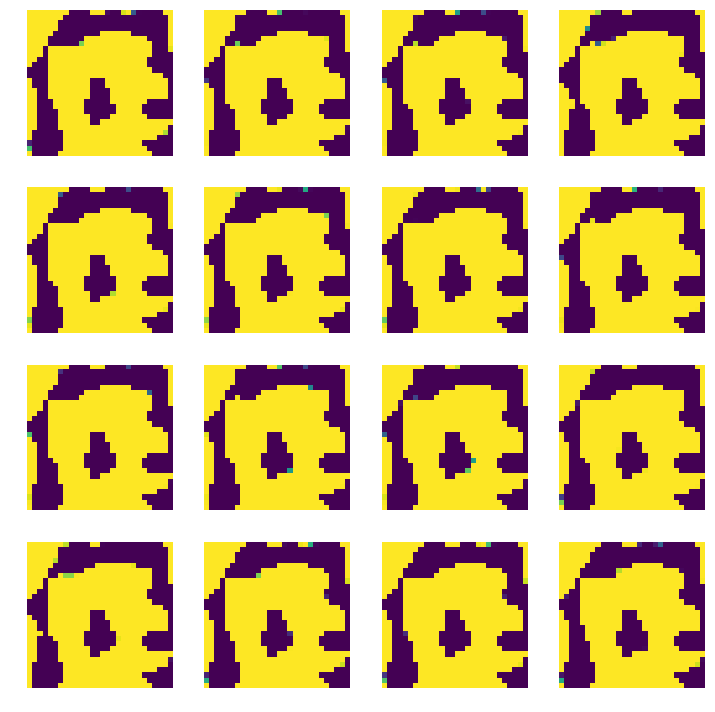

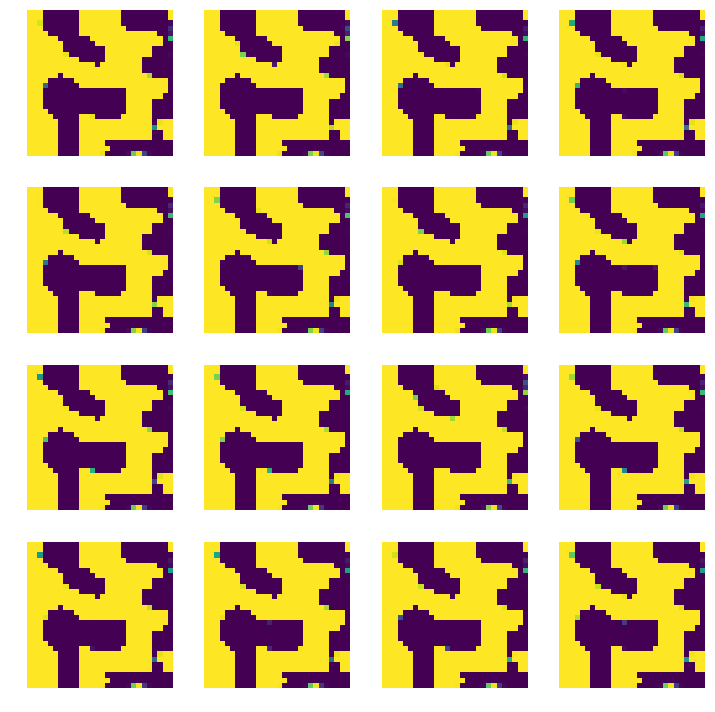

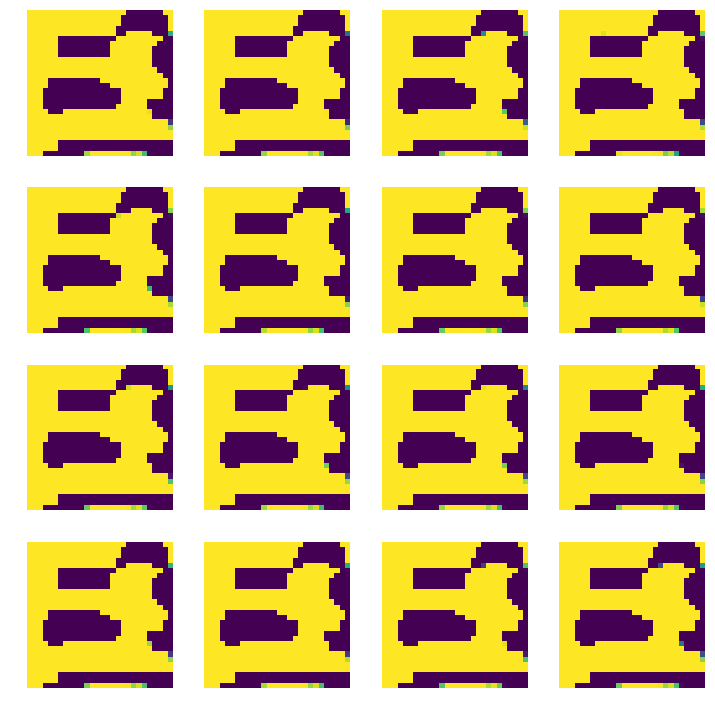

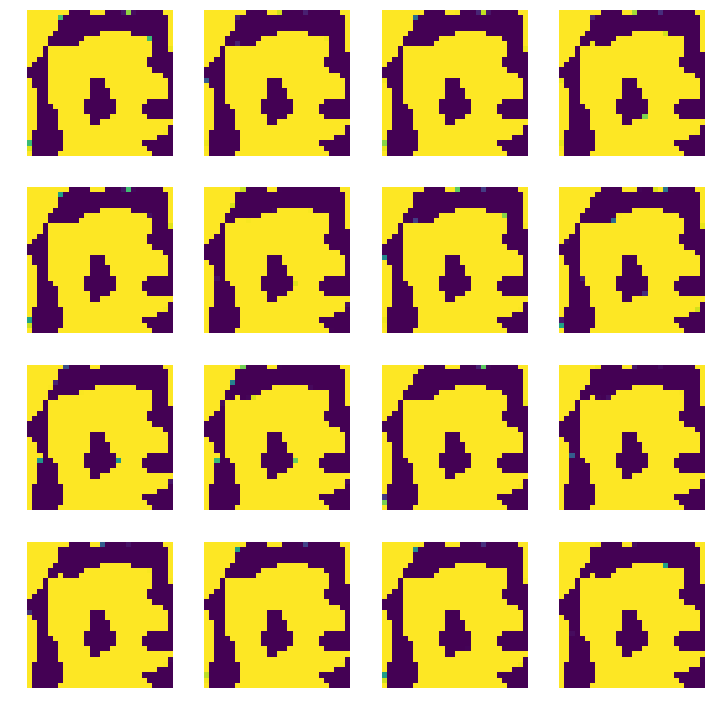

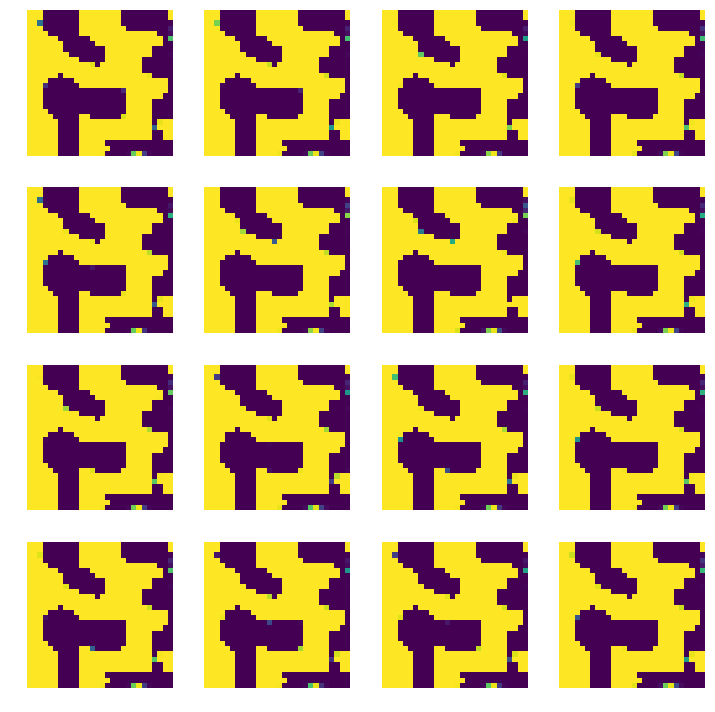

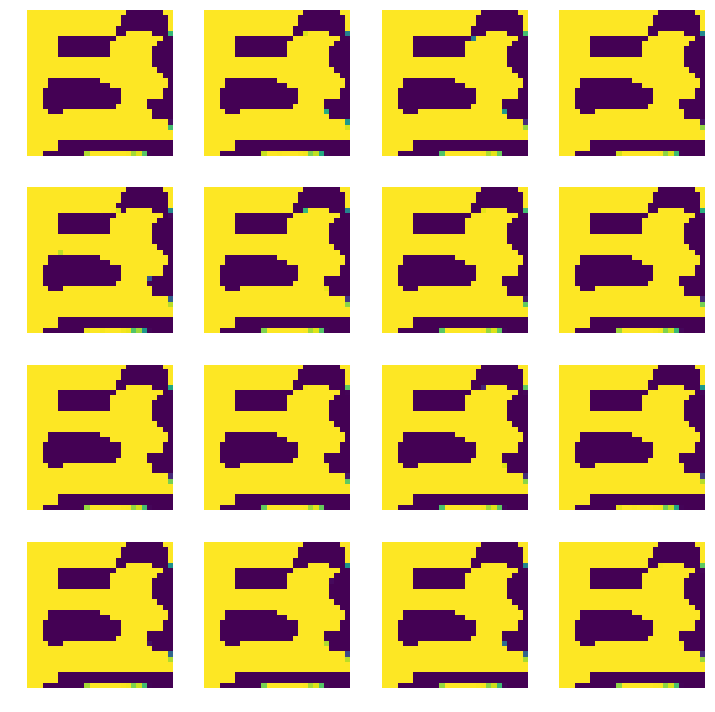

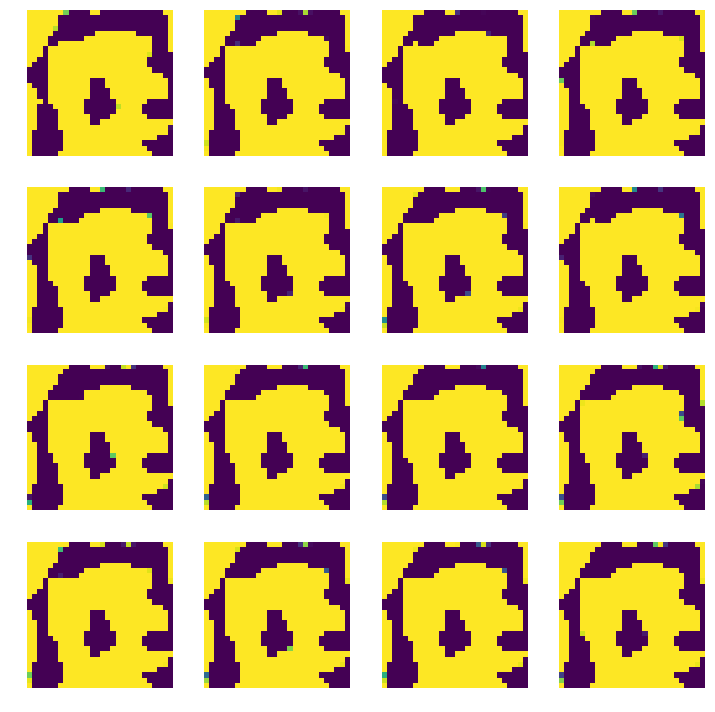

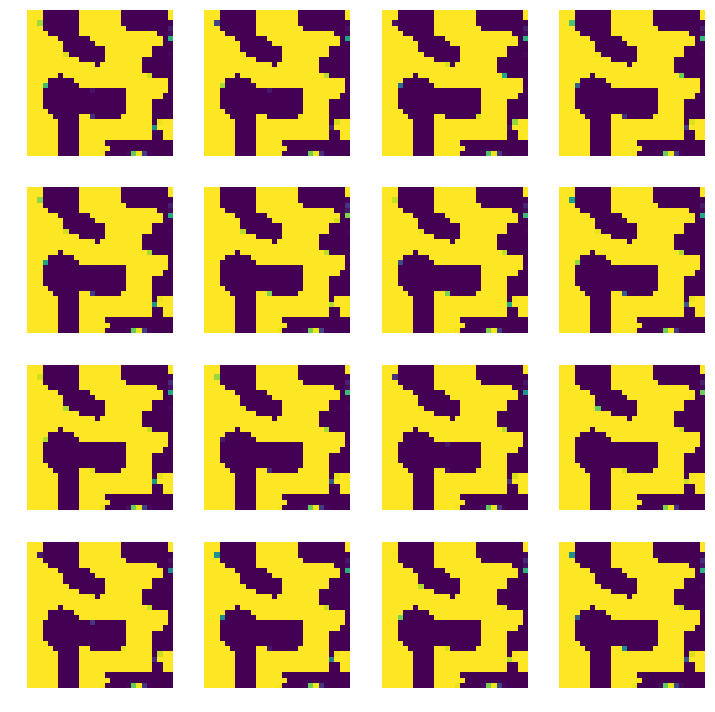

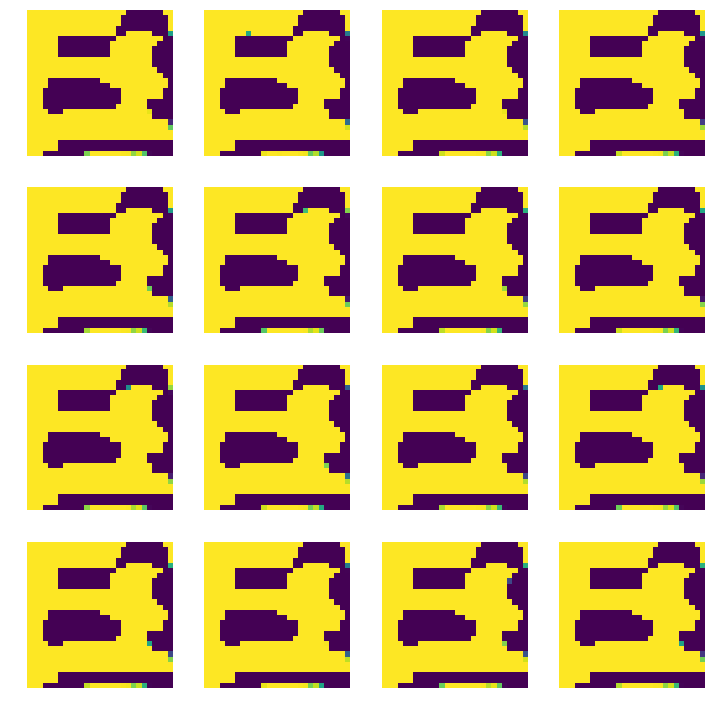

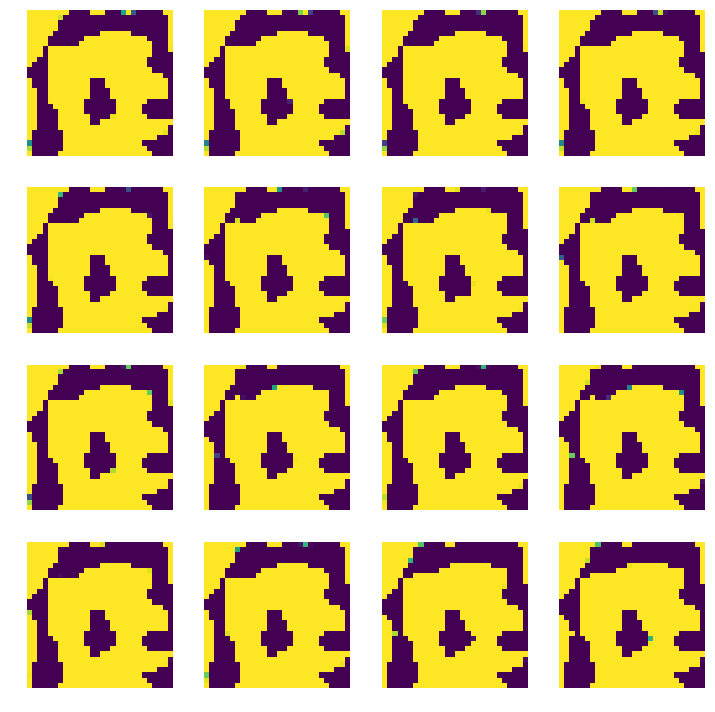

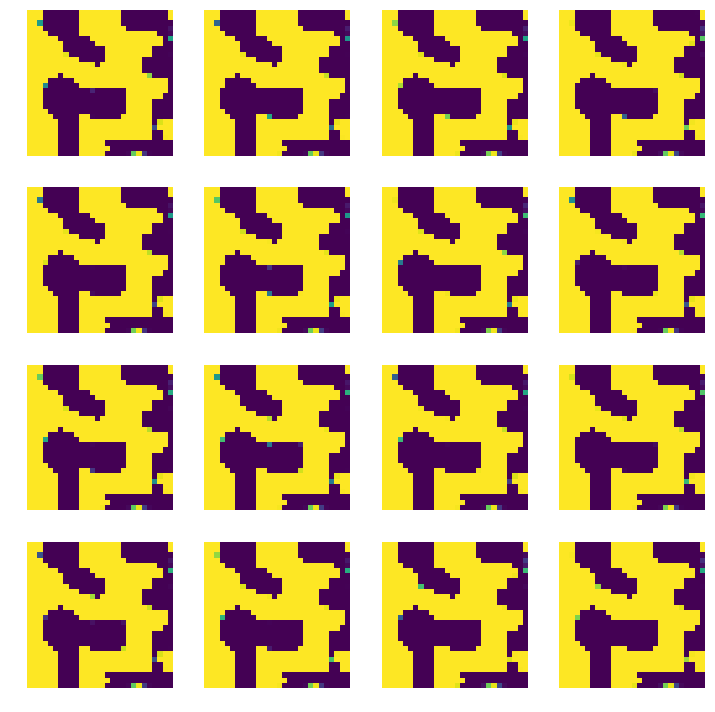

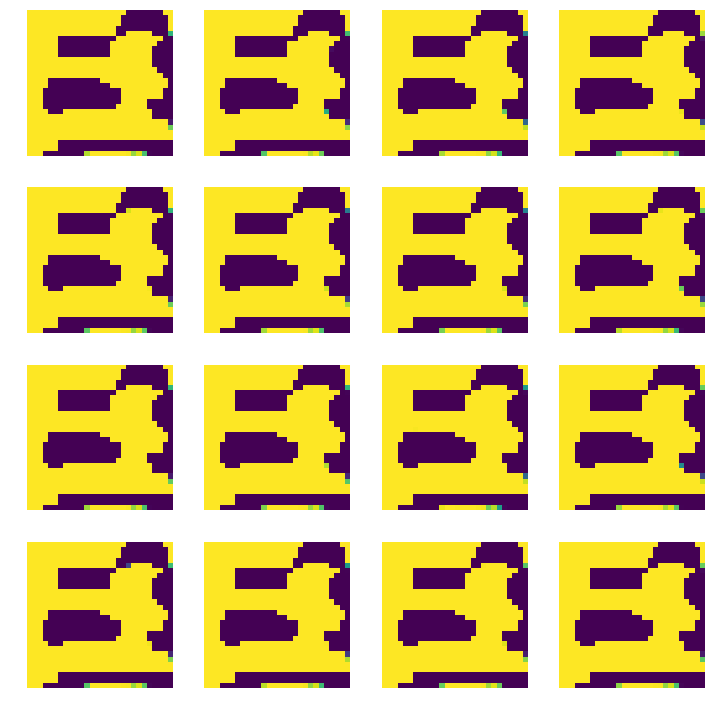

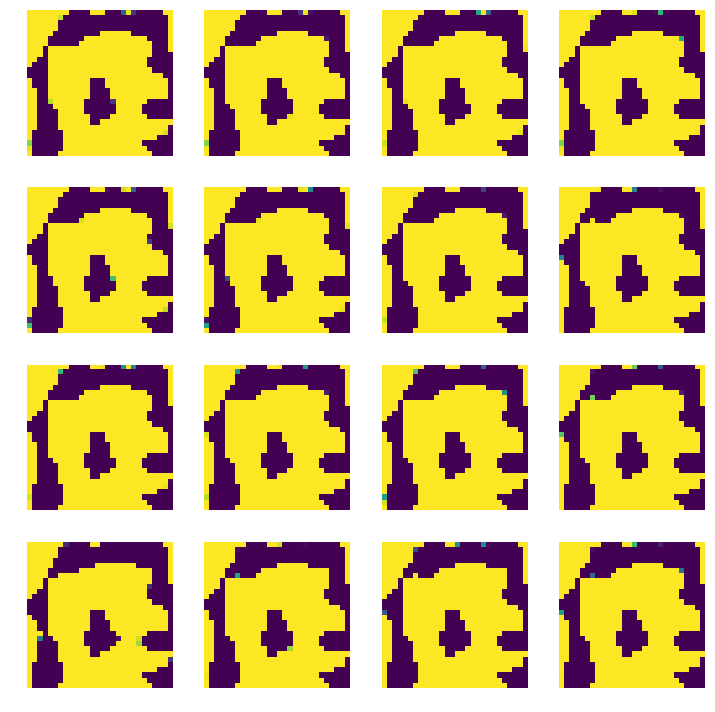

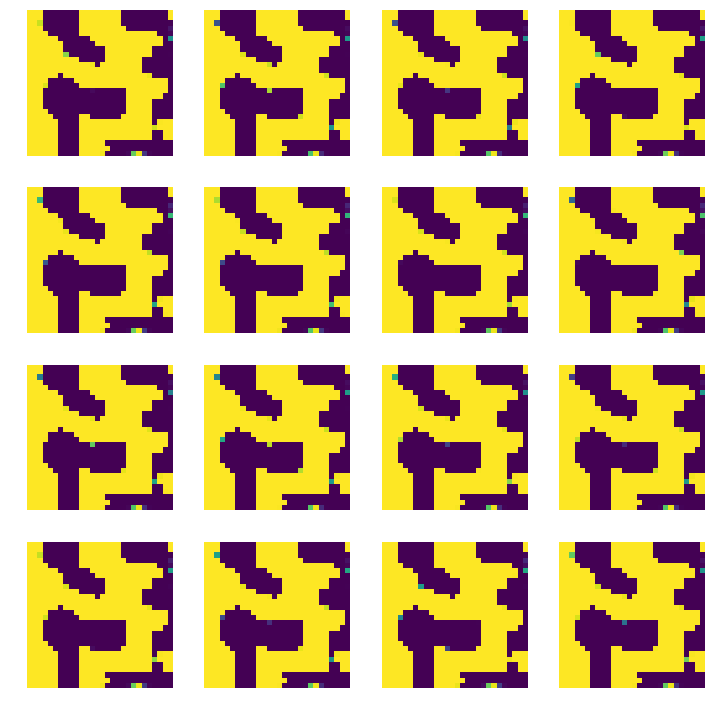

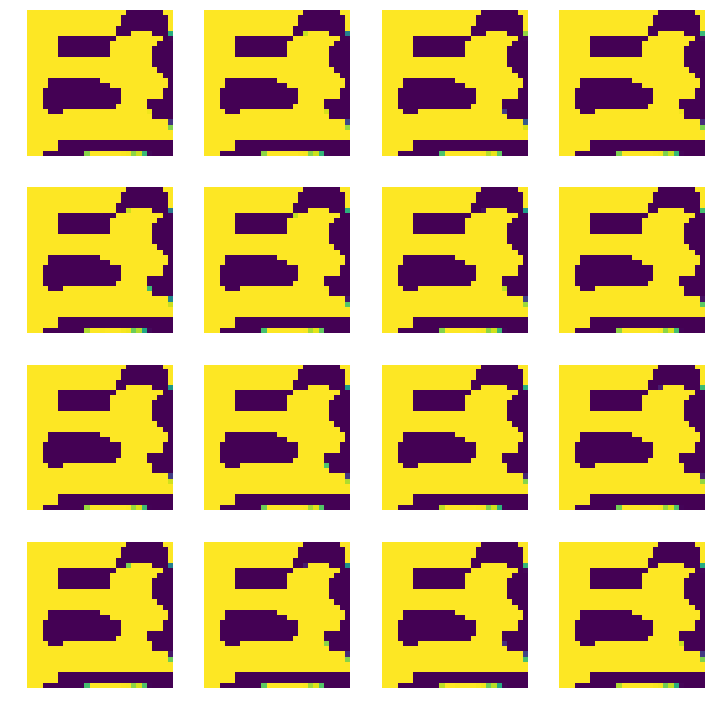

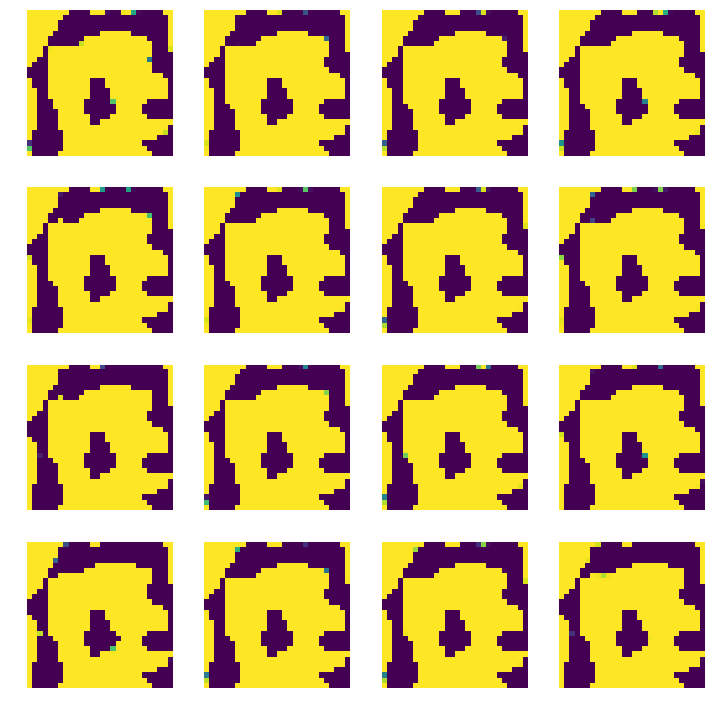

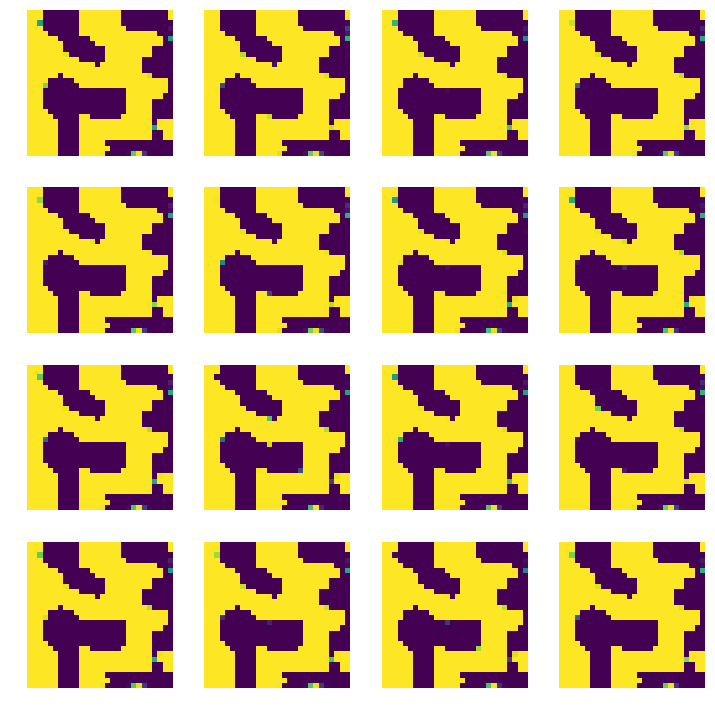

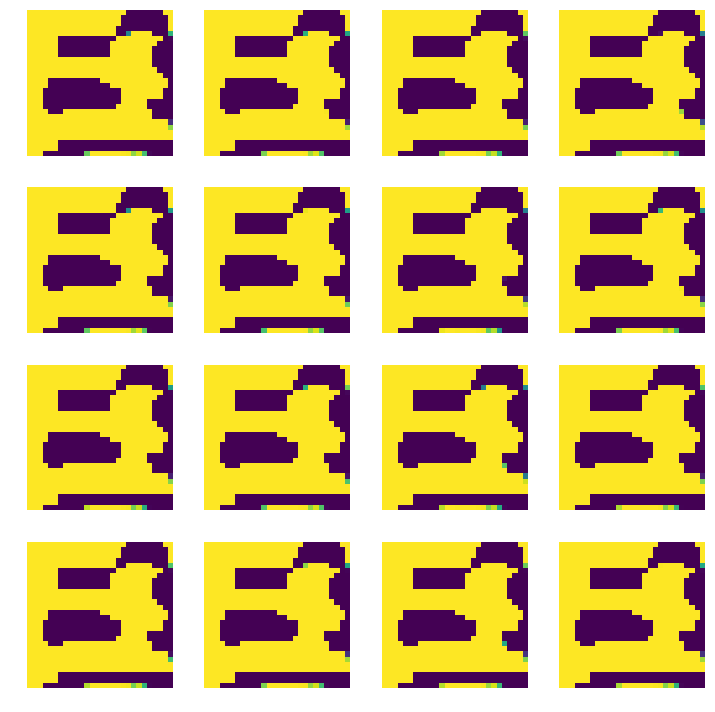

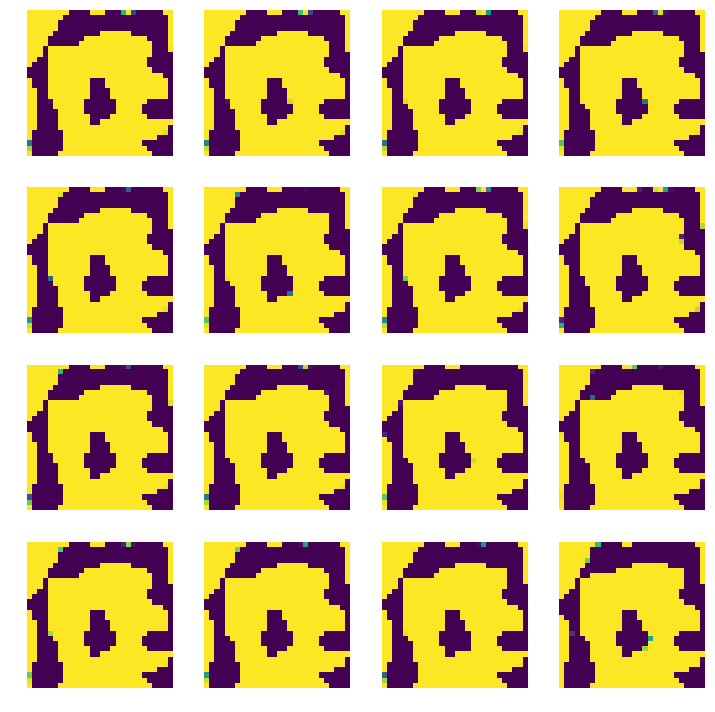

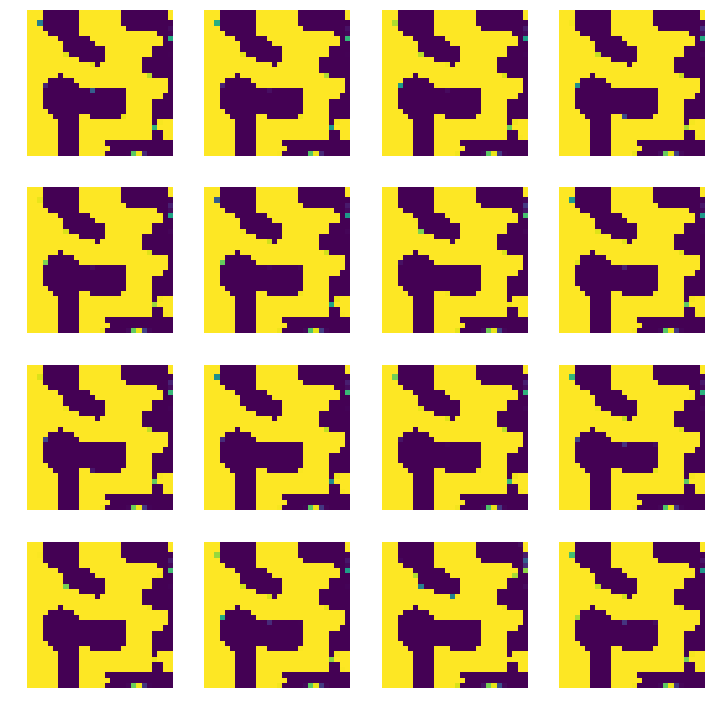

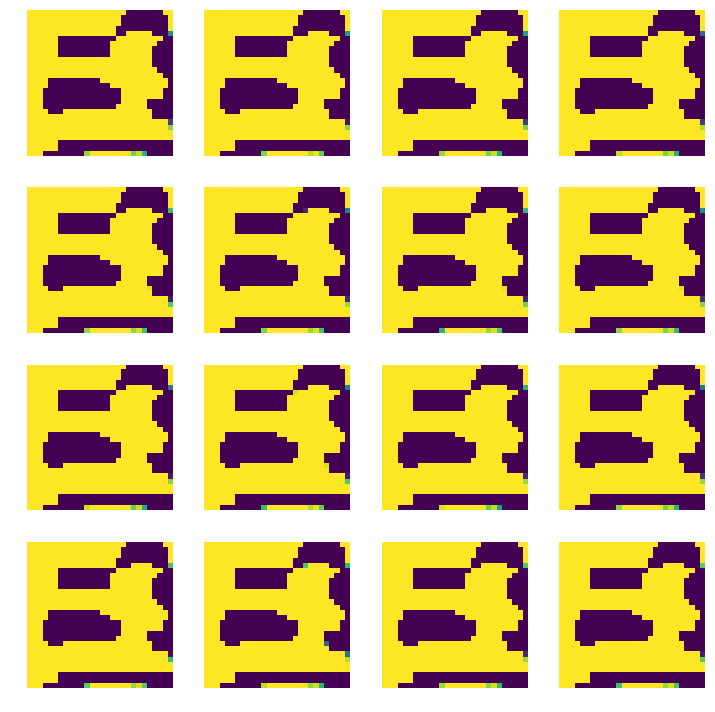

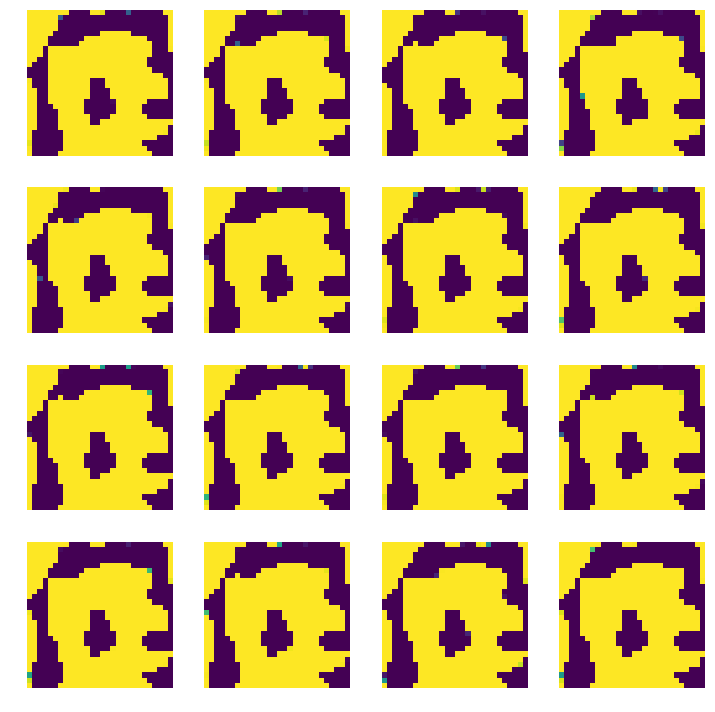

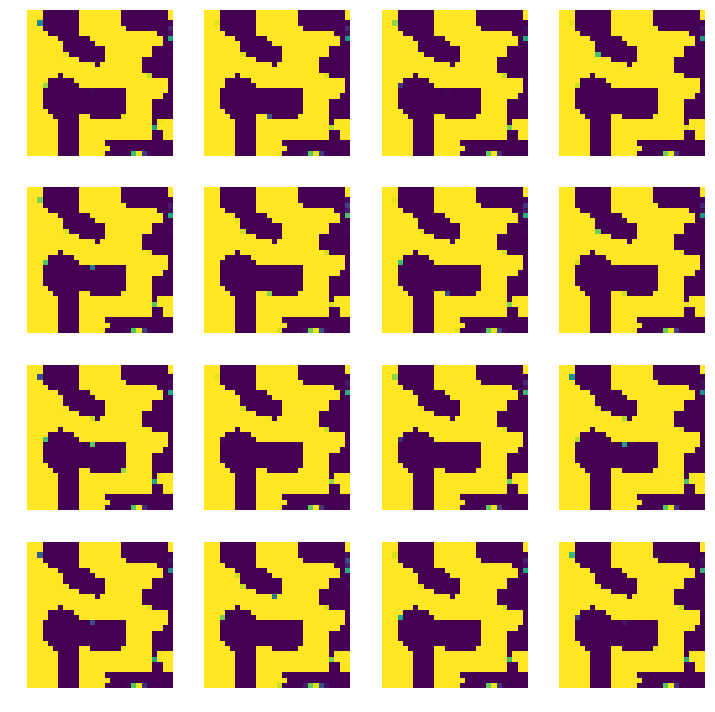

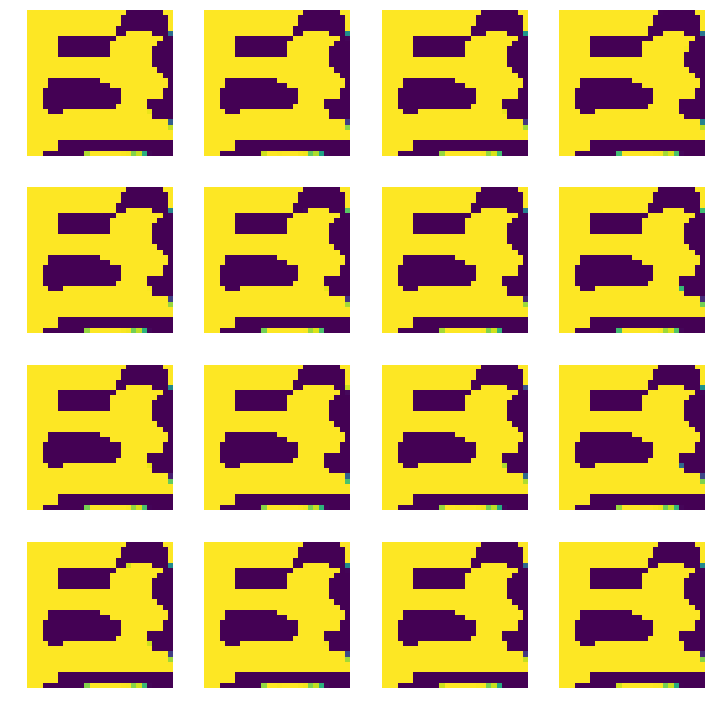

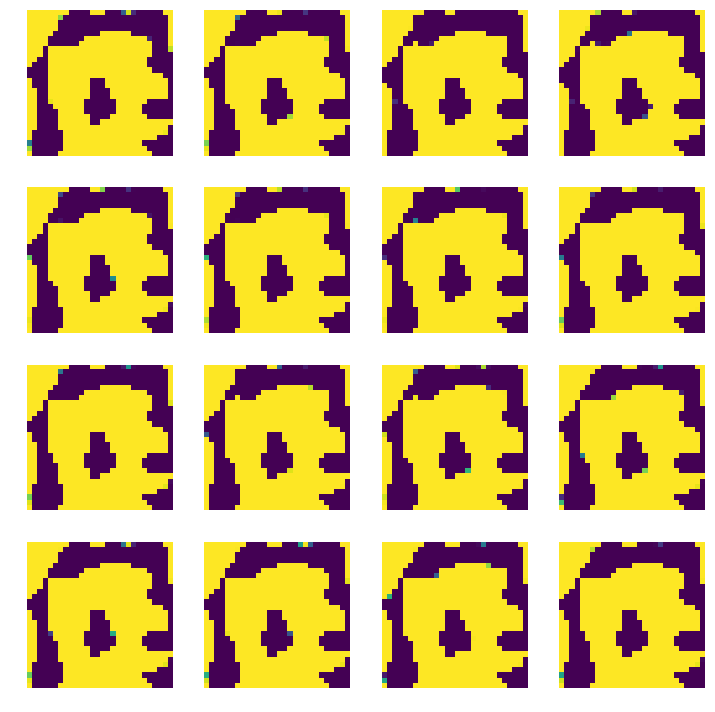

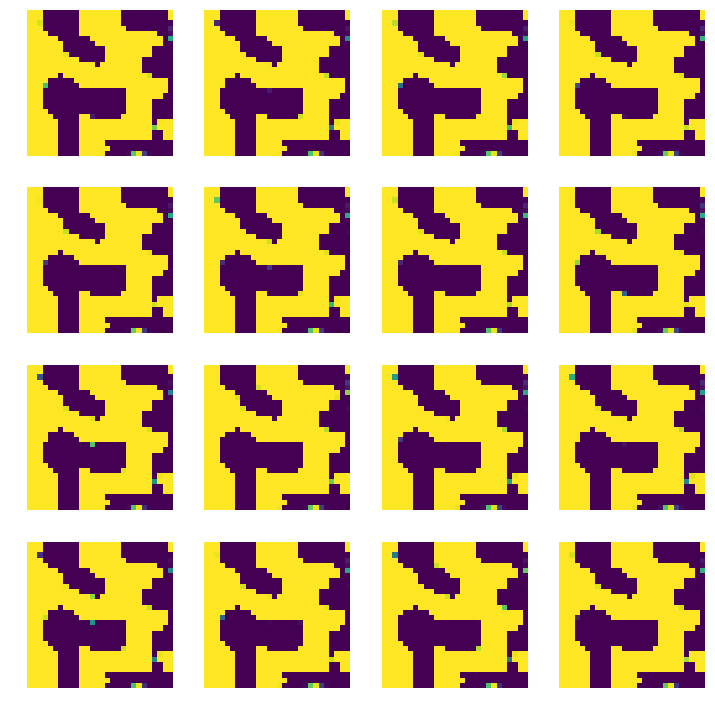

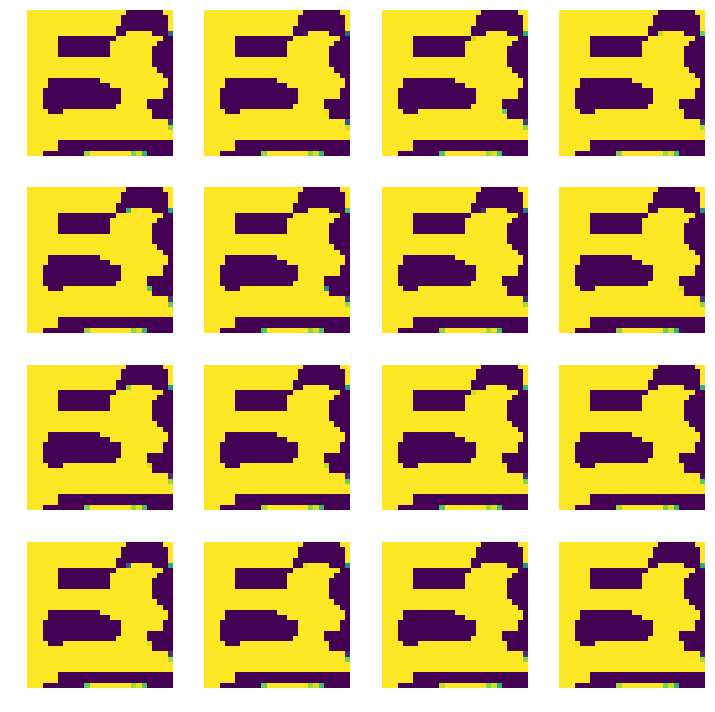

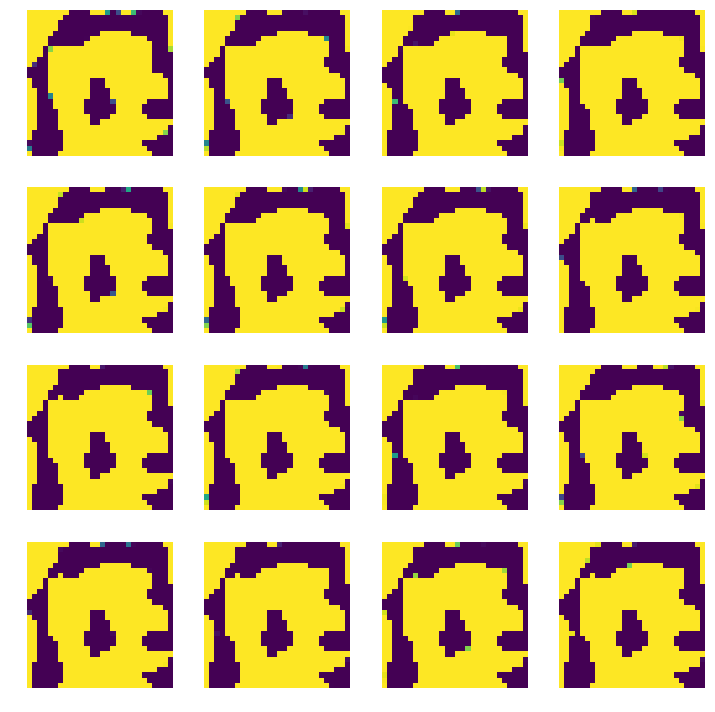

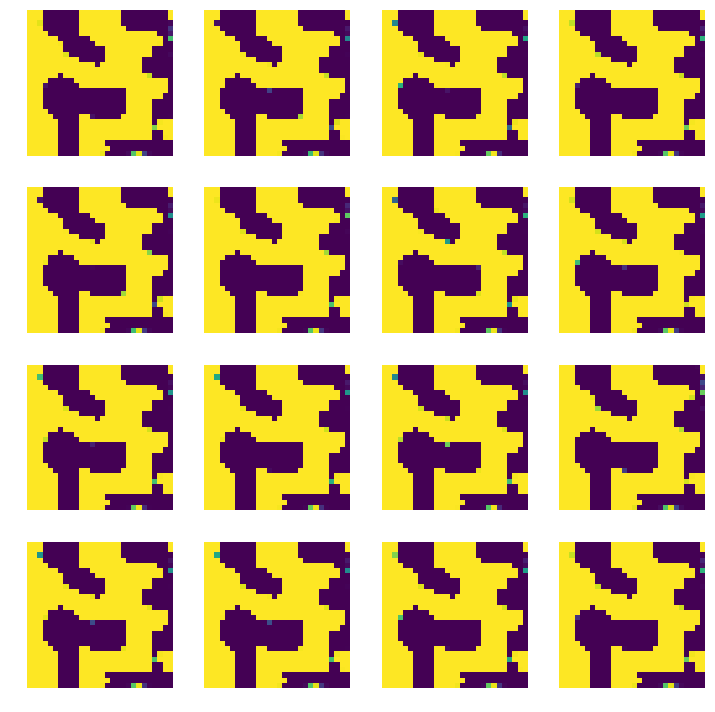

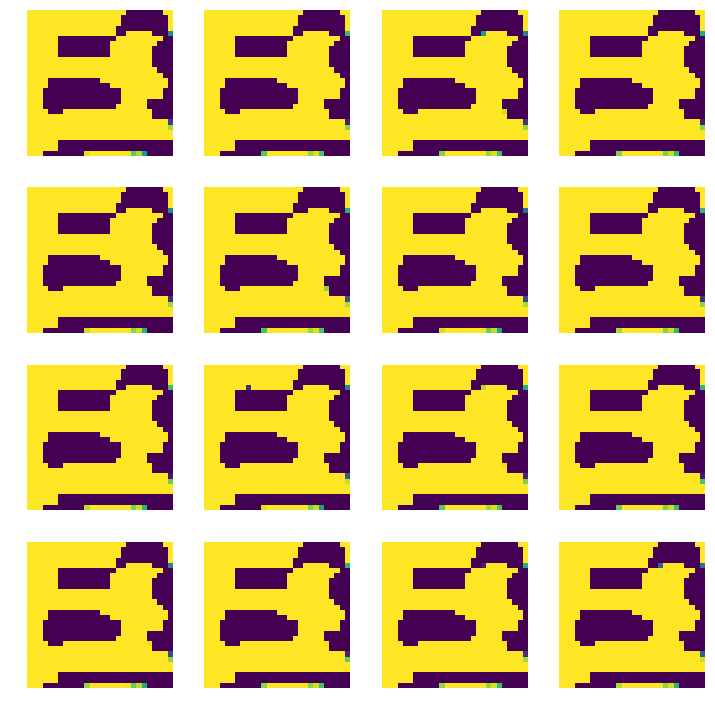

In [ ]:
%matplotlib inline
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input,merge
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Deconv2D, UpSampling2D
from keras.layers.recurrent import LSTM
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
import random, sys, keras
from keras.models import Model
from IPython import display
import _pickle
from keras.utils import np_utils
from tqdm import tqdm
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, merge, Dropout

K.set_image_dim_ordering('th')
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
#X_test /= 255
#X_train = (X_train.astype(np.float32) - 127.5) / 127.5
#X_train = np.expand_dims(X_train, axis=1)

print(np.min(X_train), np.max(X_train))

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val


shp = X_train.shape[1:]
print(shp)

dropout_rate = 0.25


opt = Adam(lr=1e-3)
dopt = Adam(lr=1e-4)


    

def build_generator(latent_size):
    latent = Input(shape=(latent_size, ))
    image_class = Input(shape=(1,))
    cls = Flatten()(Embedding(10, latent_size, init='glorot_normal')(image_class))
    
    #same as g
    cnn = Sequential()
    cnn.add(Dense(1024, input_dim=latent_size, activation='relu'))
    cnn.add(Dense(128 * 7 * 7, activation='relu'))
    cnn.add(Reshape((128, 7, 7)))
    cnn.add(UpSampling2D(size=(2, 2)))
    cnn.add(Convolution2D(256, 5, 5, border_mode='same',activation='relu', init='glorot_normal'))
    cnn.add(UpSampling2D(size=(2, 2)))
    cnn.add(Convolution2D(128, 5, 5, border_mode='same',activation='relu', init='glorot_normal'))
    cnn.add(Convolution2D(1, 2, 2, border_mode='same', activation='tanh', init='glorot_normal'))

    
    h = merge([latent, cls], mode='mul')
    fake_image = cnn(h)
    generator=Model(input=[latent, image_class], output=fake_image)
    return generator

conditonal_generator=build_generator(100)

# Build Discriminative model ...
d_input = Input(shape=shp)
H = Convolution2D(256, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Convolution2D(512, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
d_V = Dense(2,activation='softmax')(H)
d_Label = Dense(10,activation='softmax')(H)
discriminator = Model(d_input,[d_V,d_Label])
discriminator.compile(loss=['categorical_crossentropy','sparse_categorical_crossentropy'], optimizer=dopt)
discriminator.summary()



def plot_gen(n_ex=16,dim=(4,4), figsize=(10,10),num=1):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    label = np.random.randint(0+num, 1+num, n_ex)

    generated_images = conditonal_generator.predict([noise,label])

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Freeze weights in the discriminator for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val
make_trainable(discriminator, False)
# Build stacked GAN model
gan_input = Input(shape=[100])
image_class = Input(shape=(1,), dtype='int32')
H = conditonal_generator([gan_input,image_class])
gan_V,gan_c = discriminator(H)
GAN = Model([gan_input,image_class], [gan_V,gan_c])
GAN.compile(loss=['categorical_crossentropy','sparse_categorical_crossentropy'], optimizer=opt)
GAN.summary()




ntrain = 30000
trainidx = random.sample(range(0,X_train.shape[0]), ntrain)
XT = X_train[trainidx,:,:,:]
YT=  y_train[trainidx,]
# Pre-train the discriminator network ...
for i in range(1000):
    #train_d
    noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])
    sampled_labels = np.random.randint(0, 10, XT.shape[0])
    generated_images = conditonal_generator.predict([noise_gen,sampled_labels])
    X = np.concatenate((XT, generated_images))
    n = XT.shape[0]
    y = np.zeros([2*n,2])
    y[:n,1] = 1
    y[n:,0] = 1
    Y = np.concatenate((YT, sampled_labels))
    make_trainable(discriminator,True)
    discriminator.fit(X,[y,Y], epochs=1, batch_size=128,verbose=0)

    #train_g
    make_trainable(discriminator,False)
    y = np.zeros([n,2])
    y[:n,1] = 1
    noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])
    sampled_labels = np.random.randint(0, 10, XT.shape[0])
    GAN.fit([noise_gen,sampled_labels],[y,sampled_labels], epochs=1, batch_size=128,verbose=0)
    if i%2==0:
      plot_gen(num=0)  
      plot_gen(num=1)
      plot_gen(num=2)